# Machine Learning para Previs√£o de Alta/Baixa do IBOVESPA

A previs√£o de movimentos em mercados financeiros √© uma das tarefas mais desafiadoras no campo da ci√™ncia de dados e finan√ßas quantitativas. A Hip√≥tese do Mercado Eficiente (HME), em sua forma fraca, postula que todos os pre√ßos hist√≥ricos j√° est√£o refletidos no pre√ßo atual de um ativo, tornando a an√°lise de dados passados, por si s√≥, insuficiente para gerar retornos anormais de forma consistente.

O objetivo n√£o √© construir um or√°culo infal√≠vel, mas sim desenvolver um modelo de machine learning que forne√ßa uma vantagem estat√≠stica, mesmo que marginal, na previs√£o da dire√ß√£o di√°ria do √çndice Bovespa (IBOVESPA).



√â fundamental estabelecer expectativas realistas desde o in√≠cio. A natureza ca√≥tica, din√¢mica e n√£o linear dos mercados financeiros significa que a previs√£o perfeita √© uma impossibilidade te√≥rica e pr√°tica. Um modelo que demonstre um desempenho consistentemente superior ao acaso (por exemplo, uma acur√°cia de 55% com um F1-score equilibrado em dados fora da amostra) j√° pode ser considerado valioso e potencialmente explor√°vel em uma estrat√©gia de negocia√ß√£o quantitativa.

--------------------------------------------------------------------------------------------------------------
## Se√ß√£o 1: Integridade dos Dados e An√°lise Explorat√≥ria

A fase inicial de qualquer projeto de modelagem √© a mais cr√≠tica. Erros ou mal-entendidos nesta etapa se propagar√£o por todo o fluxo de trabalho, comprometendo a validade dos resultados finais.

Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss
from scipy import stats
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

# Configura√ß√£o para gr√°ficos
plt.rcParams['font.size'] = 10
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_style("whitegrid")


caminho_arquivo = 'dados_ibovespa_exemplo.csv'

1.1 - Carregamento e Valida√ß√£o Inicial dos Dados

In [2]:
def carregar_e_validar_dados(caminho_arquivo):
    """
    EAP 1.1.1, 1.1.2, 1.1.3 - Carregamento, convers√£o de data e verifica√ß√£o de integridade
    """
    print("=" * 60)
    print("EAP 1.1 - AQUISI√á√ÉO E VALIDA√á√ÉO INICIAL")
    print("=" * 60)
    
    # 1.1.1 - Carregar o dataset
    print("Carregando dados...")
    dados = pd.read_csv(caminho_arquivo)
    print(f"Dados carregados: {len(dados)} registros")
    print(f"Colunas: {list(dados.columns)}")
    
    # 1.1.2 - Converter data para datetime e definir como √≠ndice
    print("\n Convertendo data para √≠ndice...")
    
    # Identifica coluna de data
    colunas_data = [col for col in dados.columns if 'date' in col.lower()]
    if colunas_data:
        coluna_data = colunas_data[0]
    else:
        coluna_data = dados.columns[0]  # Assume primeira coluna
    
    dados[coluna_data] = pd.to_datetime(dados[coluna_data])
    dados.set_index(coluna_data, inplace=True)
    print(f"‚úì Data convertida e definida como √≠ndice")
    print(f"‚úì Per√≠odo: {dados.index.min()} at√© {dados.index.max()}")
    
    # 1.1.3 - Verifica√ß√£o de integridade
    print("\nVerificando integridade dos dados...")
    
    # Duplicatas
    duplicatas_indice = dados.index.duplicated().sum()
    duplicatas_linhas = dados.duplicated().sum()
    
    # Consist√™ncia OHLC
    inconsistencias = 0
    if all(col in dados.columns for col in ['High', 'Low', 'Close']):
        inconsistencias_high = (dados['High'] < dados['Close']).sum()
        inconsistencias_low = (dados['Low'] > dados['Close']).sum()
        inconsistencias = inconsistencias_high + inconsistencias_low
    
    # Valores nulos
    valores_nulos = dados.isnull().sum()
    
    print(f"Duplicatas no √≠ndice: {duplicatas_indice}")
    print(f"Duplicatas em linhas: {duplicatas_linhas}")
    print(f"Inconsist√™ncias OHLC: {inconsistencias}")
    print(f"Valores nulos por coluna:")
    for coluna, nulos in valores_nulos.items():
        if nulos > 0:
            print(f"   - {coluna}: {nulos}")
    
    return dados

1.2 - Limpeza e Tratamento dos Dados

In [3]:
def limpar_e_tratar_dados(dados):
    """
    EAP 1.2.1, 1.2.3 - Identifica√ß√£o de lacunas e documenta√ß√£o de outliers.
    O preenchimento com forward fill foi REMOVIDO para operar apenas com dias de preg√£o.
    """
    print("\n" + "=" * 60)
    print("EAP 1.2 - LIMPEZA E TRATAMENTO DE DADOS")
    print("=" * 60)
    
    # 1.2.1 - Identificar lacunas na s√©rie temporal (APENAS PARA AN√ÅLISE)
    print("Analisando lacunas temporais (sem alterar os dados)...")
    
    inicio = dados.index.min()
    fim = dados.index.max()
    todas_datas = pd.date_range(start=inicio, end=fim, freq='D')
    datas_ausentes = todas_datas.difference(dados.index)
    
    # Classifica lacunas
    fins_semana = datas_ausentes[datas_ausentes.weekday >= 5]
    dias_uteis_ausentes = datas_ausentes[datas_ausentes.weekday < 5]
    
    print(f"Total de datas ausentes no calend√°rio: {len(datas_ausentes)}")
    print(f"-> Sendo {len(fins_semana)} fins de semana.")
    print(f"-> E {len(dias_uteis_ausentes)} dias √∫teis (feriados).")
    
    # 1.2.2 - Bloco de forward fill REMOVIDO
    print("\nAVISO: O preenchimento com forward fill foi desativado.")
    print("O modelo operar√° apenas com os dados dos dias de preg√£o reais.")
    print(f"Mantendo os {len(dados)} registros originais.")
    
    # 1.2.3 - Documentar decis√£o sobre outliers
    print("\nDocumentando decis√£o sobre outliers...")
    print("""
    DECIS√ÉO: N√ÉO REMOVER OUTLIERS
    
    JUSTIFICATIVA:
    ‚Ä¢ Outliers em dados financeiros representam eventos leg√≠timos de mercado
    ‚Ä¢ Movimentos extremos cont√™m informa√ß√£o valiosa sobre volatilidade
    ‚Ä¢ Modelos baseados em √°rvores (XGBoost) s√£o robustos a outliers
    ‚Ä¢ Manter outliers garante realismo na modelagem
    """)
    
    # Retorna o dataframe original, sem preenchimento.
    return dados

1.3.1 - Estat√≠sticas Descritivas

In [4]:
def gerar_estatisticas_descritivas(dados):
    """
    EAP 1.3.1 - Gerar e analisar estat√≠sticas descritivas
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.1 - ESTAT√çSTICAS DESCRITIVAS")
    print("=" * 60)
    
    stats_desc = dados.describe()
    print("Estat√≠sticas Descritivas:")
    print(stats_desc)
    
    print("\nCoeficientes de Varia√ß√£o:")
    for coluna in dados.select_dtypes(include=[np.number]).columns:
        cv = dados[coluna].std() / dados[coluna].mean()
        print(f"‚úì {coluna}: {cv:.4f}")
    
    return stats_desc

1.3.2 - Gr√°ficos de Pre√ßo e Volume

In [5]:
def plotar_preco_e_volume(dados, salvar_grafico=True):
    """
    EAP 1.3.2 - Plotar gr√°fico de pre√ßo de fechamento e volume ao longo do tempo
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.2 - GR√ÅFICOS DE PRE√áO E VOLUME")
    print("=" * 60)

    # Identifica colunas com base nos nomes reais do arquivo
    col_close = '√öltimo'  # Nome exato da coluna
    col_volume = 'Vol.'   # Nome exato da coluna

    # Criar subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # Gr√°fico de pre√ßo
    ax1.plot(dados.index, dados[col_close], linewidth=1, color='blue', alpha=0.8)
    ax1.set_title('IBOVESPA - Pre√ßo de Fechamento ao Longo do Tempo', fontsize=14, fontweight='bold')
    ax1.set_ylabel('Pre√ßo de Fechamento', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.tick_params(axis='x', rotation=45)

    # Formata√ß√£o do eixo Y para pre√ßos
    ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:,.0f}'))

    # FUN√á√ÉO PARA CONVERTER VOLUME
    def converter_volume_seguro(vol_str):
        try:
            if pd.isna(vol_str) or vol_str == '-' or vol_str == '': 
                return np.nan
            vol_str = str(vol_str).replace(',', '.')
            if 'B' in vol_str: 
                return float(vol_str.replace('B', '')) * 1e9
            elif 'M' in vol_str: 
                return float(vol_str.replace('M', '')) * 1e6
            elif 'K' in vol_str: 
                return float(vol_str.replace('K', '')) * 1e3
            return float(vol_str)
        except:
            return np.nan
    
    # Converter volume para num√©rico
    print("Convertendo dados de volume...")
    volume_numerico = dados[col_volume].apply(converter_volume_seguro)
    
    # Dividir por 1e9 para mostrar em bilh√µes
    volume_bilhoes = volume_numerico / 1e9

    # Plotar volume
    ax2.fill_between(dados.index, volume_bilhoes, alpha=0.7, color='orange')
    ax2.plot(dados.index, volume_bilhoes, linewidth=0.5, color='darkorange')

    ax2.set_title('IBOVESPA - Volume de Negocia√ß√£o ao Longo do Tempo', fontsize=14, fontweight='bold')
    ax2.set_ylabel('Volume (Bilh√µes)', fontsize=12)
    ax2.set_xlabel('Data', fontsize=12)
    ax2.grid(True, alpha=0.3)
    ax2.tick_params(axis='x', rotation=45)

    # Formata√ß√£o do eixo Y para volume
    ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'{x:.1f}B'))

    # Estat√≠sticas do volume
    volume_valido = volume_numerico.dropna()
    if len(volume_valido) > 0:
        print(f"Volume m√©dio: {volume_valido.mean()/1e9:.2f} bilh√µes")
        print(f"Volume m√≠nimo: {volume_valido.min()/1e9:.2f} bilh√µes")
        print(f"Volume m√°ximo: {volume_valido.max()/1e9:.2f} bilh√µes")

    plt.tight_layout()

    if salvar_grafico:
        plt.savefig('grafico_preco_volume.png', dpi=300, bbox_inches='tight')
        print("Gr√°fico salvo como 'grafico_preco_volume.png'")

    plt.show()
    print("Gr√°ficos de pre√ßo e volume gerados")

1.3.3 - Calcular Retornos Logar√≠tmicos Di√°rios

In [6]:
def calcular_retornos_logaritmicos(dados):
    """
    EAP 1.3.3 - Calcular retornos logar√≠tmicos di√°rios
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.3 - RETORNOS LOGAR√çTMICOS")
    print("=" * 60)

    # Identifica coluna de fechamento com base no nome real
    col_close = '√öltimo' 
    

    print(f"Usando coluna de fechamento: {col_close}")

    # Calcula retornos logar√≠tmicos
    retornos = np.log(dados[col_close] / dados[col_close].shift(1))
    retornos = retornos.dropna()

    # Adiciona aos dados
    dados['Retornos_Log'] = np.log(dados[col_close] / dados[col_close].shift(1))

    print(f"Retornos calculados: {len(retornos)} observa√ß√µes")
    print(f"Estat√≠sticas dos retornos:")
    print(f"   - M√©dia: {retornos.mean():.6f}")
    print(f"   - Desvio Padr√£o: {retornos.std():.6f}")
    print(f"   - M√≠nimo: {retornos.min():.6f}")
    print(f"   - M√°ximo: {retornos.max():.6f}")
    print(f"   - Assimetria: {retornos.skew():.6f}")
    print(f"   - Curtose: {retornos.kurtosis():.6f}")

    return dados, retornos

1.3.4 - An√°lise da Distribui√ß√£o dos Retornos

In [7]:
def analisar_distribuicao_retornos(retornos, salvar_grafico=True):
    """
    EAP 1.3.4 - Plotar histograma dos retornos e analisar distribui√ß√£o
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.4 - AN√ÅLISE DA DISTRIBUI√á√ÉO DOS RETORNOS")
    print("=" * 60)

    # Cria gr√°ficos
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Histograma
    ax1.hist(retornos, bins=50, density=True, alpha=0.7, color='skyblue', edgecolor='black')
    ax1.set_title('Distribui√ß√£o dos Retornos Logar√≠tmicos Di√°rios', fontsize=14, fontweight='bold')
    ax1.set_xlabel('Retornos Logar√≠tmicos', fontsize=12)
    ax1.set_ylabel('Densidade', fontsize=12)
    ax1.grid(True, alpha=0.3)

    # Curva normal para compara√ß√£o
    mu, sigma = retornos.mean(), retornos.std()
    x = np.linspace(retornos.min(), retornos.max(), 100)
    normal_curve = (1/(sigma * np.sqrt(2 * np.pi))) * np.exp(-0.5 * ((x - mu) / sigma) ** 2)
    ax1.plot(x, normal_curve, 'r-', linewidth=2, label='Distribui√ß√£o Normal')
    ax1.legend()

    # Q-Q plot
    stats.probplot(retornos, dist="norm", plot=ax2)
    ax2.set_title('Q-Q Plot: Retornos vs Distribui√ß√£o Normal', fontsize=14, fontweight='bold')
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if salvar_grafico:
        plt.savefig('histograma_retornos.png', dpi=300, bbox_inches='tight')
        print("Gr√°fico salvo como 'histograma_retornos.png'")

    plt.show()

    # An√°lise estat√≠stica
    print("An√°lise da Distribui√ß√£o:")
    print(f"Curtose: {retornos.kurtosis():.4f} (Normal = 0)")
    if retornos.kurtosis() > 0:
        print("   ‚Üí Distribui√ß√£o leptoc√∫rtica (caudas gordas)")
    else:
        print("   ‚Üí Distribui√ß√£o platic√∫rtica (caudas finas)")

    print(f"Assimetria: {retornos.skew():.4f} (Normal = 0)")
    if abs(retornos.skew()) > 0.5:
        print("   ‚Üí Distribui√ß√£o assim√©trica")
    else:
        print("   ‚Üí Distribui√ß√£o aproximadamente sim√©trica")

    # Teste de normalidade
    from scipy.stats import jarque_bera
    jb_stat, jb_pvalue = jarque_bera(retornos)
    print(f"Teste Jarque-Bera: estat√≠stica={jb_stat:.4f}, p-valor={jb_pvalue:.6f}")
    if jb_pvalue < 0.05:
        print("   ‚Üí Rejeita hip√≥tese de normalidade (p < 0.05)")
    else:
        print("   ‚Üí N√£o rejeita hip√≥tese de normalidade (p >= 0.05)")

1.3.5 - An√°lise de Volatility Clustering

In [8]:
def analisar_volatility_clustering(retornos, salvar_grafico=True):
    """
    EAP 1.3.5 - Plotar s√©rie de retornos para identificar volatility clustering
    """
    print("\n" + "=" * 60)
    print("EAP 1.3.5 - AN√ÅLISE DE VOLATILITY CLUSTERING")
    print("=" * 60)

    # Cria gr√°ficos
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

    # S√©rie temporal dos retornos
    ax1.plot(retornos.index, retornos, linewidth=0.8, color='darkblue', alpha=0.8)
    ax1.set_title('IBOVESPA - Retornos Logar√≠tmicos Di√°rios ao Longo do Tempo',
                 fontsize=14, fontweight='bold')
    ax1.set_ylabel('Retornos Logar√≠tmicos', fontsize=12)
    ax1.grid(True, alpha=0.3)
    ax1.axhline(y=0, color='red', linestyle='--', alpha=0.7)

    # Volatilidade m√≥vel (desvio padr√£o m√≥vel de 30 dias)
    volatilidade_movel = retornos.rolling(window=30).std()
    ax2.plot(volatilidade_movel.index, volatilidade_movel,
            linewidth=1.5, color='orange', alpha=0.8)
    ax2.set_title('Volatilidade M√≥vel (30 dias) - Evid√™ncia de Agrupamento de Volatilidade',
                 fontsize=14, fontweight='bold')
    ax2.set_ylabel('Volatilidade (Desvio Padr√£o)', fontsize=12)
    ax2.set_xlabel('Data', fontsize=12)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()

    if salvar_grafico:
        plt.savefig('serie_retornos_volatilidade.png', dpi=300, bbox_inches='tight')
        print("Gr√°fico salvo como 'serie_retornos_volatilidade.png'")

    plt.show()


Execu√ß√£o da Fase 1

EXECU√á√ÉO COMPLETA DA FASE 1
EAP 1.1 - AQUISI√á√ÉO E VALIDA√á√ÉO INICIAL
Carregando dados...
Dados carregados: 3592 registros
Colunas: ['Data', '√öltimo', 'Abertura', 'M√°xima', 'M√≠nima', 'Vol.', 'Var%']

 Convertendo data para √≠ndice...
‚úì Data convertida e definida como √≠ndice
‚úì Per√≠odo: 2011-01-03 00:00:00 at√© 2025-06-30 00:00:00

Verificando integridade dos dados...
Duplicatas no √≠ndice: 0
Duplicatas em linhas: 0
Inconsist√™ncias OHLC: 0
Valores nulos por coluna:
   - Vol.: 1

EAP 1.2 - LIMPEZA E TRATAMENTO DE DADOS
Analisando lacunas temporais (sem alterar os dados)...
Total de datas ausentes no calend√°rio: 1701
-> Sendo 1512 fins de semana.
-> E 189 dias √∫teis (feriados).

AVISO: O preenchimento com forward fill foi desativado.
O modelo operar√° apenas com os dados dos dias de preg√£o reais.
Mantendo os 3592 registros originais.

Documentando decis√£o sobre outliers...

    DECIS√ÉO: N√ÉO REMOVER OUTLIERS

    JUSTIFICATIVA:
    ‚Ä¢ Outliers em dados financeiros repre

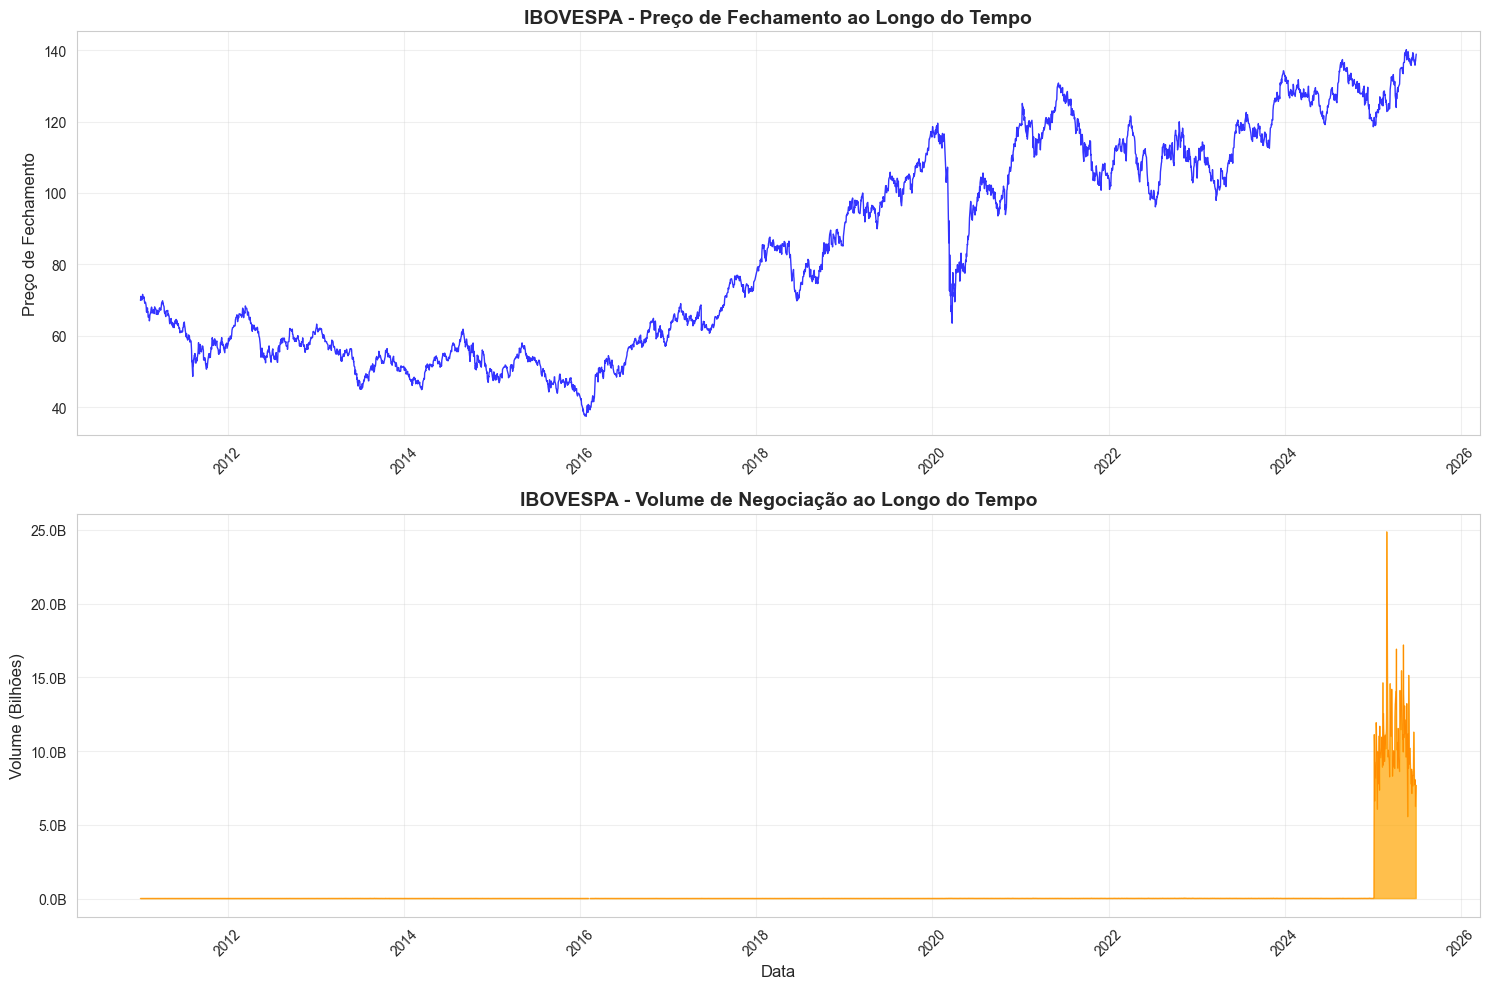

Gr√°ficos de pre√ßo e volume gerados

EAP 1.3.3 - RETORNOS LOGAR√çTMICOS
Usando coluna de fechamento: √öltimo
Retornos calculados: 3591 observa√ß√µes
Estat√≠sticas dos retornos:
   - M√©dia: -0.000191
   - Desvio Padr√£o: 0.014896
   - M√≠nimo: -0.130223
   - M√°ximo: 0.159930
   - Assimetria: 0.798093
   - Curtose: 12.271309

EAP 1.3.4 - AN√ÅLISE DA DISTRIBUI√á√ÉO DOS RETORNOS
Gr√°fico salvo como 'histograma_retornos.png'


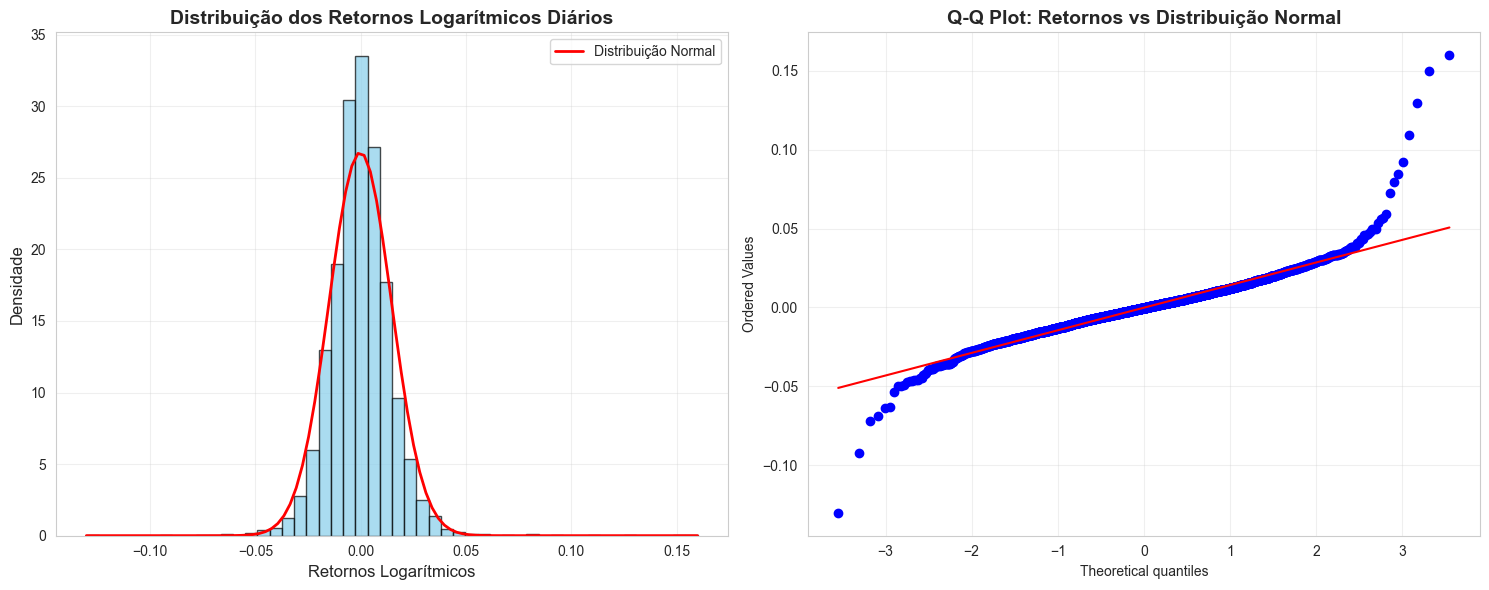

An√°lise da Distribui√ß√£o:
Curtose: 12.2713 (Normal = 0)
   ‚Üí Distribui√ß√£o leptoc√∫rtica (caudas gordas)
Assimetria: 0.7981 (Normal = 0)
   ‚Üí Distribui√ß√£o assim√©trica
Teste Jarque-Bera: estat√≠stica=22843.3807, p-valor=0.000000
   ‚Üí Rejeita hip√≥tese de normalidade (p < 0.05)

EAP 1.3.5 - AN√ÅLISE DE VOLATILITY CLUSTERING
Gr√°fico salvo como 'serie_retornos_volatilidade.png'


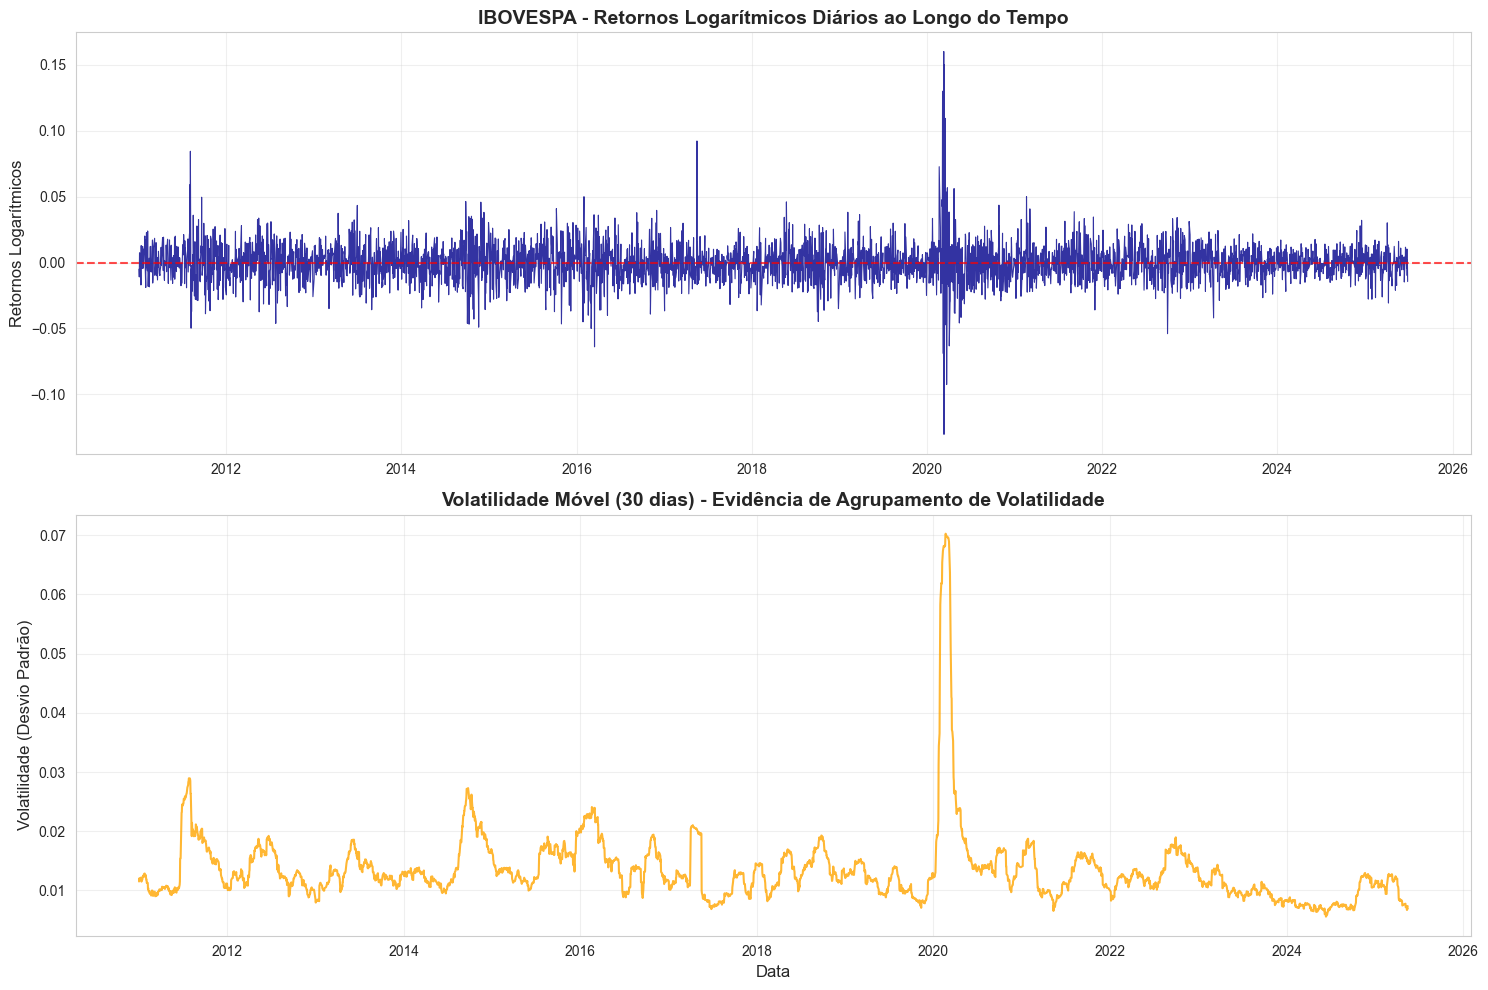

In [9]:
def executar_fase_1_completa(caminho_arquivo):
    """
    Executa toda a Fase 1 do EAP de forma sequencial
    """
    print("=" * 80)
    print("EXECU√á√ÉO COMPLETA DA FASE 1")
    print("=" * 80)

    try:
        # Executa todos os blocos sequencialmente
        dados = carregar_e_validar_dados(caminho_arquivo)
        dados_limpos = limpar_e_tratar_dados(dados)
        stats = gerar_estatisticas_descritivas(dados_limpos)
        plotar_preco_e_volume(dados_limpos)
        dados_com_retornos, retornos = calcular_retornos_logaritmicos(dados_limpos)
        analisar_distribuicao_retornos(retornos)
        analisar_volatility_clustering(retornos)


        return dados_com_retornos, {'stats': stats}

    except Exception as e:
        print(f"\nERRO NA EXECU√á√ÉO: {str(e)}")
        raise


dados, resultados = executar_fase_1_completa('dados_bovespa.csv')

Fase 1 Completa!

--------------------------------------------------------------------------------------------------------------
## Se√ß√£o 2: Defini√ß√£o do Alvo e Engenharia de Atributos

A fase de engenharia de atributos √© onde a "intelig√™ncia" do nosso modelo √© realmente criada. A qualidade das vari√°veis que geramos aqui define o potencial m√°ximo de acerto do projeto. Um erro simples nesta etapa, como usar dados do futuro para criar um indicador, pode criar um modelo que parece √≥timo nos testes, mas que n√£o funciona na vida real.


## Imports

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette('husl')

## Carregamento dos Dados

## Fun√ß√µes Auxiliares

Implementa√ß√£o manual dos indicadores t√©cnicos:

In [11]:
def calcular_sma(serie, periodo):
    """
    Calcula a M√©dia M√≥vel Simples (SMA)
    Compat√≠vel com NumPy 2.0+
    """
    return serie.rolling(window=periodo, min_periods=periodo).mean()

def calcular_retornos_log(serie):
    """
    Calcula retornos logar√≠tmicos
    Compat√≠vel com NumPy 2.0+
    """
    return np.log(serie / serie.shift(1))

def criar_lags_retornos(retornos, max_lag=5):
    """
    Cria lags dos retornos
    Compat√≠vel com NumPy 2.0+
    """
    lags = {}
    for lag in range(1, max_lag + 1):
        lags[f'Return_Lag_{lag}'] = retornos.shift(lag)
    return lags

## Carregamento dos Dados

In [12]:
# Carrega os dados limpos da Fase 1

print(f'Dados carregados: {len(dados)} registros')
print(f'Per√≠odo: {dados.index.min()} a {dados.index.max()}')
print(f'Colunas: {list(dados.columns)}')

# Visualiza as primeiras linhas
print('\n=== PRIMEIRAS LINHAS DOS DADOS ===')
dados.head()

Dados carregados: 3592 registros
Per√≠odo: 2011-01-03 00:00:00 a 2025-06-30 00:00:00
Colunas: ['√öltimo', 'Abertura', 'M√°xima', 'M√≠nima', 'Vol.', 'Var%', 'Retornos_Log']

=== PRIMEIRAS LINHAS DOS DADOS ===


√öltimo  Abertura   M√°xima   M√≠nima   Vol.    Var%  Retornos_Log
Data                                                                        
2025-06-30  138.855   136.865  139.103  136.430  7,68B   1,45%           NaN
2025-06-27  136.866   137.113  137.209  136.469  6,24B  -0,18%     -0.014428
2025-06-26  137.114   135.767  137.353  135.756  8,02B   0,99%      0.001810
2025-06-25  135.767   137.163  137.163  135.565  7,71B  -1,02%     -0.009873
2025-06-24  137.165   136.552  138.156  136.254  8,08B   0,45%      0.010244

## Cria√ß√£o da Vari√°vel Alvo (Target)

Criei a vari√°vel alvo:
- **Target = 1** se Close(t+1) > Close(t)
- **Target = 0** caso contr√°rio

In [13]:
# Copia os dados para n√£o modificar o original
dados_com_target = dados.copy()
col_close = '√öltimo'

# Cria a vari√°vel alvo
close_amanha = dados_com_target[col_close].shift(-1)
close_hoje = dados_com_target[col_close]
dados_com_target['Target'] = (close_amanha > close_hoje).astype(int)

# Remove a √∫ltima linha que cont√©m NaN no Target
dados_com_target = dados_com_target.dropna(subset=['Target'])

print('\n=== CRIA√á√ÉO DA VARI√ÅVEL ALVO ===')
print('Vari√°vel Target criada com sucesso')
print('L√≥gica: Target = 1 se Close(t+1) > Close(t), 0 caso contr√°rio')
print(f'Registros ap√≥s remo√ß√£o de NaN: {len(dados_com_target)}')

# Visualiza os primeiros registros com o target
print('\n=== PRIMEIROS REGISTROS COM TARGET ===')
dados_com_target[['Abertura', 'M√°xima', 'M√≠nima', '√öltimo', 'Target']].head(10)


=== CRIA√á√ÉO DA VARI√ÅVEL ALVO ===
Vari√°vel Target criada com sucesso
L√≥gica: Target = 1 se Close(t+1) > Close(t), 0 caso contr√°rio
Registros ap√≥s remo√ß√£o de NaN: 3592

=== PRIMEIROS REGISTROS COM TARGET ===


Abertura   M√°xima   M√≠nima   √öltimo  Target
Data                                                   
2025-06-30   136.865  139.103  136.430  138.855       0
2025-06-27   137.113  137.209  136.469  136.866       1
2025-06-26   135.767  137.353  135.756  137.114       0
2025-06-25   137.163  137.163  135.565  135.767       1
2025-06-24   136.552  138.156  136.254  137.165       0
2025-06-23   137.116  137.130  135.835  136.551       1
2025-06-20   138.715  138.719  136.815  137.116       1
2025-06-18   138.844  139.161  138.443  138.717       1
2025-06-17   139.256  139.497  138.293  138.840       1
2025-06-16   137.212  139.988  137.212  139.256       0

## An√°lise da Distribui√ß√£o de Classes

=== AN√ÅLISE DA DISTRIBUI√á√ÉO DE CLASSES ===
‚úì Distribui√ß√£o absoluta:
   - Classe 0: 1836 (51.11%)
   - Classe 1: 1756 (48.89%)

‚úì An√°lise de desbalanceamento:
   - Classe majorit√°ria: 0 (51.11%)
   - Raz√£o de desbalanceamento: 1.05:1
   - Status: BALANCEADO (raz√£o <= 1.5)


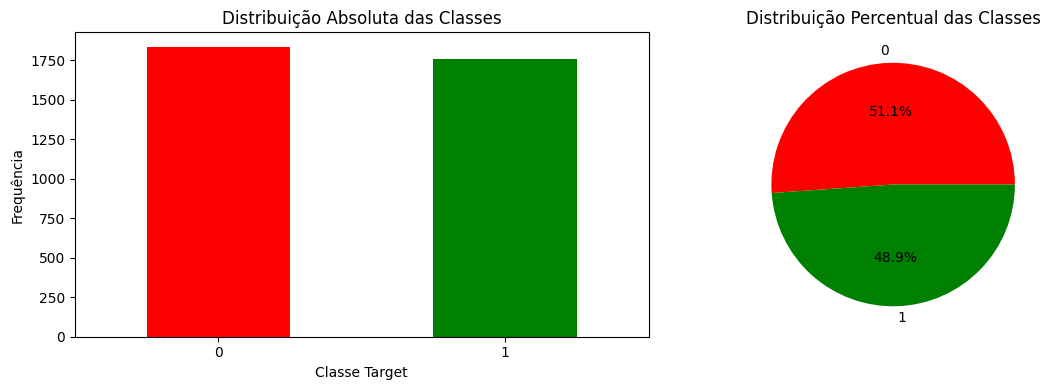

In [14]:
# Calcula e analisa a frequ√™ncia das classes 0 e 1
distribuicao = dados_com_target['Target'].value_counts()
proporcoes = dados_com_target['Target'].value_counts(normalize=True)

# An√°lise de desbalanceamento
classe_majoritaria = proporcoes.idxmax()
prop_majoritaria = proporcoes.max()
prop_minoritaria = proporcoes.min()
razao_desbalanceamento = prop_majoritaria / prop_minoritaria

print('=== AN√ÅLISE DA DISTRIBUI√á√ÉO DE CLASSES ===')
print('‚úì Distribui√ß√£o absoluta:')
for classe, count in distribuicao.items():
    print(f'   - Classe {classe}: {count} ({proporcoes[classe]:.2%})')

print('\n‚úì An√°lise de desbalanceamento:')
print(f'   - Classe majorit√°ria: {classe_majoritaria} ({prop_majoritaria:.2%})')
print(f'   - Raz√£o de desbalanceamento: {razao_desbalanceamento:.2f}:1')

if razao_desbalanceamento > 1.5:
    print('   - Status: DESBALANCEADO (raz√£o > 1.5)')
    print('   - Implica√ß√µes:')
    print('     ‚Ä¢ Acur√°cia n√£o √© uma m√©trica confi√°vel')
    print('     ‚Ä¢ Usar Precis√£o, Recall e F1-Score')
    print('     ‚Ä¢ Considerar scale_pos_weight no XGBoost')
else:
    print('   - Status: BALANCEADO (raz√£o <= 1.5)')

# Visualiza√ß√£o gr√°fica
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Gr√°fico de barras
distribuicao.plot(kind='bar', ax=ax1, color=['red', 'green'])
ax1.set_title('Distribui√ß√£o Absoluta das Classes')
ax1.set_xlabel('Classe Target')
ax1.set_ylabel('Frequ√™ncia')
ax1.tick_params(axis='x', rotation=0)

# Gr√°fico de pizza
proporcoes.plot(kind='pie', ax=ax2, autopct='%1.1f%%', colors=['red', 'green'])
ax2.set_title('Distribui√ß√£o Percentual das Classes')
ax2.set_ylabel('')

plt.tight_layout()
plt.show()

## Engenharia de Atributos

### Atributos de Momento (Lags de Retornos)

In [15]:
# Copia os dados com target para adicionar features
dados_com_features = dados_com_target.copy()

# Calcula retornos logar√≠tmicos usando fun√ß√£o manual
dados_com_features['Retornos_Log'] = calcular_retornos_log(dados_com_features[col_close])

# Dicion√°rio para armazenar informa√ß√µes dos atributos criados
dicionario_atributos = {}

# Cria lags dos retornos (1 a 5 dias)
print('=== CRIANDO ATRIBUTOS DE MOMENTO ===')
print('Usando implementa√ß√£o manual')

lags_retornos = criar_lags_retornos(dados_com_features['Retornos_Log'], 5)
for col_name, serie_lag in lags_retornos.items():
    dados_com_features[col_name] = serie_lag
    lag_num = col_name.split('_')[-1]
    
    # Adiciona ao dicion√°rio de atributos
    dicionario_atributos[col_name] = {
        'calculo': f'log(Close(t-{lag_num}) / Close(t-{lag_num}-1))',
        'dados_entrada': 'Close',
        'intuicao_financeira': f'Captura o momentum de {lag_num} dia(s) atr√°s',
        'categoria': 'Momento'
    }
    print(f'Criado: {col_name}')

print('\nAtributos de momento criados com sucesso!')
print('Capturam informa√ß√µes de momentum de curto prazo')

# Visualiza os novos atributos
colunas_momento = [f'Return_Lag_{i}' for i in range(1, 6)]
print('\n=== PRIMEIROS REGISTROS COM ATRIBUTOS DE MOMENTO ===')
dados_com_features[['√öltimo', 'Retornos_Log'] + colunas_momento + ['Target']].head(10)

=== CRIANDO ATRIBUTOS DE MOMENTO ===
Usando implementa√ß√£o manual
Criado: Return_Lag_1
Criado: Return_Lag_2
Criado: Return_Lag_3
Criado: Return_Lag_4
Criado: Return_Lag_5

Atributos de momento criados com sucesso!
Capturam informa√ß√µes de momentum de curto prazo

=== PRIMEIROS REGISTROS COM ATRIBUTOS DE MOMENTO ===


√öltimo  Retornos_Log  Return_Lag_1  Return_Lag_2  Return_Lag_3  \
Data                                                                          
2025-06-30  138.855           NaN           NaN           NaN           NaN   
2025-06-27  136.866     -0.014428           NaN           NaN           NaN   
2025-06-26  137.114      0.001810     -0.014428           NaN           NaN   
2025-06-25  135.767     -0.009873      0.001810     -0.014428           NaN   
2025-06-24  137.165      0.010244     -0.009873      0.001810     -0.014428   
2025-06-23  136.551     -0.004486      0.010244     -0.009873      0.001810   
2025-06-20  137.116      0.004129     -0.004486      0.010244     -0.009873   
2025-06-18  138.717      0.011609      0.004129     -0.004486      0.010244   
2025-06-17  138.840      0.000886      0.011609      0.004129     -0.004486   
2025-06-16  139.256      0.002992      0.000886      0.011609      0.004129   

            Return_Lag_4  Return_Lag_5  Target  
Data                                            
2025-06-30           NaN           NaN       0  
2025-06-27           NaN           NaN       1  
2025-06-26           NaN           NaN       0  
2025-06-25           NaN           NaN       1  
2025-06-24           NaN           NaN       0  
2025-06-23     -0.014428           NaN       1  
2025-06-20      0.001810     -0.014428       1  
2025-06-18     -0.009873      0.001810       1  
2025-06-17      0.010244     -0.009873       1  
2025-06-16     -0.004486      0.010244       0

### Atributos de Tend√™ncia (SMAs e Ratios)

In [16]:
# Cria m√©dias m√≥veis simples usando fun√ß√£o manual
periodos_sma = [5, 10, 20]


for periodo in periodos_sma:
    col_name = f'SMA_{periodo}'
    dados_com_features[col_name] = calcular_sma(dados_com_features[col_close], periodo)
    
    # Adiciona ao dicion√°rio de atributos
    dicionario_atributos[col_name] = {
        'calculo': f'M√©dia m√≥vel simples de {periodo} per√≠odos',
        'dados_entrada': 'Close',
        'intuicao_financeira': f'Tend√™ncia de {"curto" if periodo <= 10 else "m√©dio"} prazo',
        'categoria': 'Tend√™ncia'
    }

# Cria ratios entre pre√ßo e SMAs

for periodo in periodos_sma:
    col_name = f'Close_SMA_{periodo}_Ratio'
    dados_com_features[col_name] = dados_com_features[col_close] / dados_com_features[f'SMA_{periodo}']
    
    # Adiciona ao dicion√°rio de atributos
    dicionario_atributos[col_name] = {
        'calculo': f'Close / SMA_{periodo}',
        'dados_entrada': 'Close, SMA',
        'intuicao_financeira': f'Posi√ß√£o relativa do pre√ßo vs tend√™ncia de {periodo} dias',
        'categoria': 'Tend√™ncia'
    }

# Cria ratios entre SMAs
dados_com_features['SMA_5_10_Ratio'] = dados_com_features['SMA_5'] / dados_com_features['SMA_10']
dados_com_features['SMA_10_20_Ratio'] = dados_com_features['SMA_10'] / dados_com_features['SMA_20']

# Adiciona ao dicion√°rio
dicionario_atributos['SMA_5_10_Ratio'] = {
    'calculo': 'SMA_5 / SMA_10',
    'dados_entrada': 'SMA_5, SMA_10',
    'intuicao_financeira': 'Diverg√™ncia entre tend√™ncias de curto e m√©dio prazo',
    'categoria': 'Tend√™ncia'
}

dicionario_atributos['SMA_10_20_Ratio'] = {
    'calculo': 'SMA_10 / SMA_20',
    'dados_entrada': 'SMA_10, SMA_20',
    'intuicao_financeira': 'Diverg√™ncia entre tend√™ncias de m√©dio prazo',
    'categoria': 'Tend√™ncia'
}

## Finaliza√ß√£o e Limpeza dos Dados

In [17]:
# Remove registros com NaN (causados pelos lags e m√©dias m√≥veis)
dados_finais = dados_com_features.dropna()

print('=== FINALIZA√á√ÉO DOS DADOS ===')
print(f'Registros antes da limpeza: {len(dados_com_features)}')
print(f'Registros ap√≥s limpeza: {len(dados_finais)}')
print(f'Registros removidos: {len(dados_com_features) - len(dados_finais)}')
print(f'Total de colunas: {len(dados_finais.columns)}')

# Lista todas as colunas criadas
colunas_originais = dados.columns.tolist()
colunas_criadas = [col for col in dados_finais.columns if col not in colunas_originais]

print(f'\nColunas criadas ({len(colunas_criadas)}): {colunas_criadas}')

# Verifica distribui√ß√£o final do target
distribuicao_final = dados_finais['Target'].value_counts(normalize=True)
print(f'\nDistribui√ß√£o final do Target:')
for classe, prop in distribuicao_final.items():
    print(f'   - Classe {classe}: {prop:.2%}')

# Salva os dados processados
dados_finais.to_csv('dados_fase2_completos.csv')
print(f'\nDados salvos em: dados_fase2_completos.csv')

# Salva o dicion√°rio de atributos
with open('dicionario_atributos_fase2.json', 'w', encoding='utf-8') as f:
    json.dump(dicionario_atributos, f, indent=2, ensure_ascii=False)
print(f'Dicion√°rio salvo em: dicionario_atributos_fase2.json')

# Visualiza o dataset final
print('\n=== DATASET FINAL ===')
dados_finais.head()

=== FINALIZA√á√ÉO DOS DADOS ===
Registros antes da limpeza: 3592
Registros ap√≥s limpeza: 3572
Registros removidos: 20
Total de colunas: 21

Colunas criadas (14): ['Target', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5', 'SMA_5', 'SMA_10', 'SMA_20', 'Close_SMA_5_Ratio', 'Close_SMA_10_Ratio', 'Close_SMA_20_Ratio', 'SMA_5_10_Ratio', 'SMA_10_20_Ratio']

Distribui√ß√£o final do Target:
   - Classe 0: 51.18%
   - Classe 1: 48.82%

Dados salvos em: dados_fase2_completos.csv
Dicion√°rio salvo em: dicionario_atributos_fase2.json

=== DATASET FINAL ===


√öltimo  Abertura   M√°xima   M√≠nima    Vol.    Var%  Retornos_Log  \
Data                                                                            
2025-06-02  136.787   137.026  138.471  136.483   9,10B  -0,18%     -0.005533   
2025-05-30  137.027   138.546  138.637  136.726  15,14B  -1,09%      0.001753   
2025-05-29  138.534   138.869  139.108  137.993   8,83B  -0,25%      0.010938   
2025-05-28  138.888   139.541  139.547  138.580   9,73B  -0,47%      0.002552   
2025-05-27  139.541   138.136  140.382  138.136  11,19B   1,02%      0.004691   

            Target  Return_Lag_1  Return_Lag_2  ...  Return_Lag_4  \
Data                                            ...                 
2025-06-02       1      0.003963      0.005607  ...      0.002965   
2025-05-30       1     -0.005533      0.003963  ...      0.000984   
2025-05-29       1      0.001753     -0.005533  ...      0.005607   
2025-05-28       1      0.010938      0.001753  ...      0.003963   
2025-05-27       0      0.002552      0.010938  ...     -0.005533   

            Return_Lag_5     SMA_5    SMA_10    SMA_20  Close_SMA_5_Ratio  \
Data                                                                        
2025-06-02     -0.005416  136.7346  136.7949  137.2098           1.000383   
2025-05-30      0.002965  136.9196  136.7763  137.1184           1.000784   
2025-05-29      0.000984  137.3792  136.8497  137.2018           1.008406   
2025-05-28      0.005607  137.7564  137.0257  137.2905           1.008215   
2025-05-27      0.003963  138.1554  137.3362  137.4792           1.010029   

            Close_SMA_10_Ratio  Close_SMA_20_Ratio  SMA_5_10_Ratio  \
Data                                                                 
2025-06-02            0.999942            0.996919        0.999559   
2025-05-30            1.001833            0.999333        1.001048   
2025-05-29            1.012308            1.009710        1.003869   
2025-05-28            1.013591            1.011636        1.005333   
2025-05-27            1.016054            1.014997        1.005965   

            SMA_10_20_Ratio  
Data                         
2025-06-02         0.996976  
2025-05-30         0.997505  
2025-05-29         0.997434  
2025-05-28         0.998071  
2025-05-27         0.998960  

[5 rows x 21 columns]

Fase 2 Completa!

--------------------------------------------------------------------------------------------------------------
## Se√ß√£o 3: Prepara√ß√£o da Base para Modelagem

A Fase 3 √© a arruma√ß√£o final dos dados antes de entreg√°-los para o modelo. A tarefa mais cr√≠tica aqui √© dividir o dataset em treino e teste. A regra de ouro √© nunca misturar o tempo: usamos o passado para treinar e separamos o futuro para testar. Se errarmos nessa divis√£o, o modelo pode "colar" as respostas do futuro, nos dando uma falsa impress√£o de acerto, quando na pr√°tica ele n√£o saberia prever nada.


## Imports

In [18]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import json

warnings.filterwarnings('ignore')
plt.style.use('default')
sns.set_palette('husl')

## Carregamento dos Dados da Fase 2

In [19]:
# Carrega os dados processados da Fase 2
dados_com_features = pd.read_csv('dados_fase2_completos.csv', index_col=0, parse_dates=True)

print(f'\n=== INFORMA√á√ïES DOS DADOS ===')
print(f'Registros: {len(dados_com_features)}')
print(f'Per√≠odo: {dados_com_features.index.min()} a {dados_com_features.index.max()}')
print(f'Colunas: {len(dados_com_features.columns)}')
print(f'Colunas dispon√≠veis: {list(dados_com_features.columns)}')

# Visualiza as primeiras linhas
print('\n=== PRIMEIRAS LINHAS DOS DADOS ===')
dados_com_features.head()


=== INFORMA√á√ïES DOS DADOS ===
Registros: 3572
Per√≠odo: 2011-01-03 00:00:00 a 2025-06-02 00:00:00
Colunas: 21
Colunas dispon√≠veis: ['√öltimo', 'Abertura', 'M√°xima', 'M√≠nima', 'Vol.', 'Var%', 'Retornos_Log', 'Target', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3', 'Return_Lag_4', 'Return_Lag_5', 'SMA_5', 'SMA_10', 'SMA_20', 'Close_SMA_5_Ratio', 'Close_SMA_10_Ratio', 'Close_SMA_20_Ratio', 'SMA_5_10_Ratio', 'SMA_10_20_Ratio']

=== PRIMEIRAS LINHAS DOS DADOS ===


√öltimo  Abertura   M√°xima   M√≠nima    Vol.    Var%  Retornos_Log  \
Data                                                                            
2025-06-02  136.787   137.026  138.471  136.483   9,10B  -0,18%     -0.005533   
2025-05-30  137.027   138.546  138.637  136.726  15,14B  -1,09%      0.001753   
2025-05-29  138.534   138.869  139.108  137.993   8,83B  -0,25%      0.010938   
2025-05-28  138.888   139.541  139.547  138.580   9,73B  -0,47%      0.002552   
2025-05-27  139.541   138.136  140.382  138.136  11,19B   1,02%      0.004691   

            Target  Return_Lag_1  Return_Lag_2  ...  Return_Lag_4  \
Data                                            ...                 
2025-06-02       1      0.003963      0.005607  ...      0.002965   
2025-05-30       1     -0.005533      0.003963  ...      0.000984   
2025-05-29       1      0.001753     -0.005533  ...      0.005607   
2025-05-28       1      0.010938      0.001753  ...      0.003963   
2025-05-27       0      0.002552      0.010938  ...     -0.005533   

            Return_Lag_5     SMA_5    SMA_10    SMA_20  Close_SMA_5_Ratio  \
Data                                                                        
2025-06-02     -0.005416  136.7346  136.7949  137.2098           1.000383   
2025-05-30      0.002965  136.9196  136.7763  137.1184           1.000784   
2025-05-29      0.000984  137.3792  136.8497  137.2018           1.008406   
2025-05-28      0.005607  137.7564  137.0257  137.2905           1.008215   
2025-05-27      0.003963  138.1554  137.3362  137.4792           1.010029   

            Close_SMA_10_Ratio  Close_SMA_20_Ratio  SMA_5_10_Ratio  \
Data                                                                 
2025-06-02            0.999942            0.996919        0.999559   
2025-05-30            1.001833            0.999333        1.001048   
2025-05-29            1.012308            1.009710        1.003869   
2025-05-28            1.013591            1.011636        1.005333   
2025-05-27            1.016054            1.014997        1.005965   

            SMA_10_20_Ratio  
Data                         
2025-06-02         0.996976  
2025-05-30         0.997505  
2025-05-29         0.997434  
2025-05-28         0.998071  
2025-05-27         0.998960  

[5 rows x 21 columns]

## Estrutura√ß√£o com Janela Deslizante

### Defini√ß√£o da Janela de Entrada (Lookback Window)

Transformei a s√©rie temporal em um dataset tabular onde cada linha cont√©m os atributos dos √∫ltimos **n=5 dias** e o alvo correspondente.

In [20]:
# Configura√ß√µes da janela deslizante
JANELA_TAMANHO = 5  # Lookback window de 5 dias

print(f'=== ESTRUTURA√á√ÉO COM JANELA DESLIZANTE ===')
print(f'Tamanho da janela: {JANELA_TAMANHO} dias')

# Converter colunas cr√≠ticas para num√©rico ANTES da sele√ß√£o
print('\n=== CONVERTENDO COLUNAS CR√çTICAS ===')

# Converter Volume se ainda estiver como string
if 'Vol.' in dados_com_features.columns and dados_com_features['Vol.'].dtype == 'object':
    def converter_volume_seguro(vol_str):
        try:
            if pd.isna(vol_str) or vol_str == '-': return np.nan
            vol_str = str(vol_str).replace(',', '.')
            if 'B' in vol_str: return float(vol_str.replace('B', '')) * 1e9
            elif 'M' in vol_str: return float(vol_str.replace('M', '')) * 1e6
            elif 'K' in vol_str: return float(vol_str.replace('K', '')) * 1e3
            return float(vol_str)
        except: return np.nan
    
    dados_com_features['Vol.'] = dados_com_features['Vol.'].apply(converter_volume_seguro)
    print("‚úì Volume convertido para num√©rico")

# Converter Varia√ß√£o se ainda estiver como string  
if 'Var%' in dados_com_features.columns and dados_com_features['Var%'].dtype == 'object':
    def converter_variacao(var_str):
        try:
            if pd.isna(var_str): return np.nan
            var_str = str(var_str).replace('%', '').replace(',', '.')
            return float(var_str)
        except: return np.nan
    
    dados_com_features['Var%'] = dados_com_features['Var%'].apply(converter_variacao)
    print("‚úì Varia√ß√£o convertida para num√©rico")

# Identifica features num√©ricas (exclui Target)
colunas_excluir = ['Target']
features_numericas = dados_com_features.select_dtypes(include=[np.number]).columns
features_numericas = [col for col in features_numericas if col not in colunas_excluir]

print(f'\nFeatures selecionadas: {len(features_numericas)}')
print(f'Features: {features_numericas[:10]}...')  # Mostra apenas as primeiras 10

# Remove linhas com NaN nas features
dados_limpos = dados_com_features[features_numericas + ['Target']].dropna()
print(f'Dados limpos: {len(dados_limpos)} registros')

=== ESTRUTURA√á√ÉO COM JANELA DESLIZANTE ===
Tamanho da janela: 5 dias

=== CONVERTENDO COLUNAS CR√çTICAS ===
‚úì Volume convertido para num√©rico
‚úì Varia√ß√£o convertida para num√©rico

Features selecionadas: 20
Features: ['√öltimo', 'Abertura', 'M√°xima', 'M√≠nima', 'Vol.', 'Var%', 'Retornos_Log', 'Return_Lag_1', 'Return_Lag_2', 'Return_Lag_3']...
Dados limpos: 3572 registros


### Implementa√ß√£o da L√≥gica de Janela Deslizante

In [21]:
# Cria estrutura de janela deslizante
print('=== CRIANDO ESTRUTURA DE JANELA DESLIZANTE ===')

X_list = []
y_list = []
indices_list = []

# Itera pelos dados criando janelas deslizantes
for i in range(JANELA_TAMANHO, len(dados_limpos)):
    # Janela de features (√∫ltimos n dias)
    janela_features = dados_limpos[features_numericas].iloc[i-JANELA_TAMANHO:i].values
    
    # Achata a janela (transforma matriz em vetor)
    janela_achatada = janela_features.flatten()
    
    # Target correspondente
    target = dados_limpos['Target'].iloc[i]
    
    X_list.append(janela_achatada)
    y_list.append(target)
    indices_list.append(dados_limpos.index[i])

# Converte para arrays numpy
X = np.array(X_list)
y = np.array(y_list)

print(f'Janelas criadas: {len(X_list)}')
print(f'Shape do X: {X.shape}')
print(f'Shape do y: {y.shape}')

# Cria nomes das colunas para o DataFrame final
nomes_colunas = []
for lag in range(JANELA_TAMANHO, 0, -1):
    for feature in features_numericas:
        nomes_colunas.append(f"{feature}_lag_{lag}")

print(f'Colunas criadas: {len(nomes_colunas)}')
print(f'Exemplo de colunas: {nomes_colunas[:5]}...')

# Cria DataFrame estruturado
dados_janela_deslizante = pd.DataFrame(
    X, 
    columns=nomes_colunas,
    index=indices_list
)
dados_janela_deslizante['Target'] = y

print(f'\nDataset estruturado criado: {X.shape[0]} amostras, {X.shape[1]} features')
print(f'Cada amostra cont√©m {JANELA_TAMANHO} dias de {len(features_numericas)} features')

# Visualiza as primeiras linhas
print('\n=== PRIMEIRAS LINHAS DO DATASET ESTRUTURADO ===')
dados_janela_deslizante.head()

=== CRIANDO ESTRUTURA DE JANELA DESLIZANTE ===
Janelas criadas: 3567
Shape do X: (3567, 100)
Shape do y: (3567,)
Colunas criadas: 100
Exemplo de colunas: ['√öltimo_lag_5', 'Abertura_lag_5', 'M√°xima_lag_5', 'M√≠nima_lag_5', 'Vol._lag_5']...

Dataset estruturado criado: 3567 amostras, 100 features
Cada amostra cont√©m 5 dias de 20 features

=== PRIMEIRAS LINHAS DO DATASET ESTRUTURADO ===


√öltimo_lag_5  Abertura_lag_5  M√°xima_lag_5  M√≠nima_lag_5  \
2025-05-26       136.787         137.026       138.471       136.483   
2025-05-23       137.027         138.546       138.637       136.726   
2025-05-22       138.534         138.869       139.108       137.993   
2025-05-21       138.888         139.541       139.547       138.580   
2025-05-20       139.541         138.136       140.382       138.136   

              Vol._lag_5  Var%_lag_5  Retornos_Log_lag_5  Return_Lag_1_lag_5  \
2025-05-26  9.100000e+09       -0.18           -0.005533            0.003963   
2025-05-23  1.514000e+10       -1.09            0.001753           -0.005533   
2025-05-22  8.830000e+09       -0.25            0.010938            0.001753   
2025-05-21  9.730000e+09       -0.47            0.002552            0.010938   
2025-05-20  1.119000e+10        1.02            0.004691            0.002552   

            Return_Lag_2_lag_5  Return_Lag_3_lag_5  ...  Return_Lag_5_lag_1  \
2025-05-26            0.005607            0.000984  ...            0.003963   
2025-05-23            0.003963            0.005607  ...           -0.005533   
2025-05-22           -0.005533            0.003963  ...            0.001753   
2025-05-21            0.001753           -0.005533  ...            0.010938   
2025-05-20            0.010938            0.001753  ...            0.002552   

            SMA_5_lag_1  SMA_10_lag_1  SMA_20_lag_1  Close_SMA_5_Ratio_lag_1  \
2025-05-26     138.1554      137.3362     137.47920                 1.010029   
2025-05-23     138.4252      137.5799     137.52775                 0.997911   
2025-05-22     138.5846      137.7521     137.59140                 0.994512   
2025-05-21     138.3324      137.8558     137.59925                 0.992342   
2025-05-20     138.1310      137.9437     137.55745                 0.998190   

            Close_SMA_10_Ratio_lag_1  Close_SMA_20_Ratio_lag_1  \
2025-05-26                  1.016054                  1.014997   
2025-05-23                  1.004042                  1.004423   
2025-05-22                  1.000522                  1.001691   
2025-05-21                  0.995772                  0.997629   
2025-05-20                  0.999545                  1.002352   

            SMA_5_10_Ratio_lag_1  SMA_10_20_Ratio_lag_1  Target  
2025-05-26              1.005965               0.998960       0  
2025-05-23              1.006144               1.000379       0  
2025-05-22              1.006043               1.001168       1  
2025-05-21              1.003457               1.001864       1  
2025-05-20              1.001358               1.002808       0  

[5 rows x 101 columns]

## Divis√£o Cronol√≥gica dos Dados

### Defini√ß√£o da Data de Corte

Separamos os dados em treino, valida√ß√£o e teste **sem usar amostragem aleat√≥ria**, respeitando a ordem cronol√≥gica.

In [22]:
# Configura√ß√µes da divis√£o
DIAS_TESTE = 30  # √öltimos 30 dias √∫teis para teste
PROPORCAO_VALIDACAO = 0.2  # 20% do restante para valida√ß√£o

print(f'=== DIVIS√ÉO CRONOL√ìGICA DOS DADOS ===')
print(f'‚úì Estrat√©gia: √öltimos {DIAS_TESTE} dias para teste, restante dividido treino/valida√ß√£o')

# Calcula pontos de corte
total_amostras = len(dados_janela_deslizante)

# Teste: √∫ltimos 30 dias √∫teis
ponto_corte_teste = max(0, total_amostras - DIAS_TESTE)

# Valida√ß√£o: 20% do que sobrou
dados_restantes = total_amostras - DIAS_TESTE
ponto_corte_validacao = int(dados_restantes * (1 - PROPORCAO_VALIDACAO))

print(f'Total de amostras: {total_amostras}')
print(f'Teste: {DIAS_TESTE} dias (√∫ltimos)')
print(f'Valida√ß√£o: {dados_restantes - ponto_corte_validacao} dias')
print(f'Treino: {ponto_corte_validacao} dias')

# Datas de corte
data_corte_validacao = dados_janela_deslizante.index[ponto_corte_validacao]
data_corte_teste = dados_janela_deslizante.index[ponto_corte_teste]

print(f'\nData corte treino/valida√ß√£o: {data_corte_validacao}')
print(f'Data corte valida√ß√£o/teste: {data_corte_teste}')

# Separa√ß√£o cronol√≥gica
dados_treino = dados_janela_deslizante.iloc[:ponto_corte_validacao]
dados_validacao = dados_janela_deslizante.iloc[ponto_corte_validacao:ponto_corte_teste]
dados_teste = dados_janela_deslizante.iloc[ponto_corte_teste:]

print(f'\n=== PER√çODOS FINAIS ===')
print(f'Treino: {dados_treino.index.min()} at√© {dados_treino.index.max()} ({len(dados_treino)} amostras)')
print(f'Valida√ß√£o: {dados_validacao.index.min()} at√© {dados_validacao.index.max()} ({len(dados_validacao)} amostras)')
print(f'Teste: {dados_teste.index.min()} at√© {dados_teste.index.max()} ({len(dados_teste)} amostras)')

# Propor√ß√µes finais
prop_treino = len(dados_treino) / total_amostras
prop_validacao = len(dados_validacao) / total_amostras
prop_teste = len(dados_teste) / total_amostras

print(f'\n=== PROPOR√á√ïES FINAIS ===')
print(f'Treino: {prop_treino:.1%}')
print(f'Valida√ß√£o: {prop_validacao:.1%}')
print(f'Teste: {prop_teste:.1%}')

=== DIVIS√ÉO CRONOL√ìGICA DOS DADOS ===
‚úì Estrat√©gia: √öltimos 30 dias para teste, restante dividido treino/valida√ß√£o
Total de amostras: 3567
Teste: 30 dias (√∫ltimos)
Valida√ß√£o: 708 dias
Treino: 2829 dias

Data corte treino/valida√ß√£o: 2013-12-19 00:00:00
Data corte valida√ß√£o/teste: 2011-02-14 00:00:00

=== PER√çODOS FINAIS ===
Treino: 2013-12-20 00:00:00 at√© 2025-05-26 00:00:00 (2829 amostras)
Valida√ß√£o: 2011-02-15 00:00:00 at√© 2013-12-19 00:00:00 (708 amostras)
Teste: 2011-01-03 00:00:00 at√© 2011-02-14 00:00:00 (30 amostras)

=== PROPOR√á√ïES FINAIS ===
Treino: 79.3%
Valida√ß√£o: 19.8%
Teste: 0.8%


### 4.2 Separa√ß√£o de Features e Target

=== SEPARA√á√ÉO DE FEATURES E TARGET ===
Features: 100
X_train shape: (2829, 100)
y_train shape: (2829,)
X_val shape: (708, 100)
y_val shape: (708,)
X_test shape: (30, 100)
y_test shape: (30,)

Distribui√ß√£o de classes no treino:
   - Classe 0: 51.82%
   - Classe 1: 48.18%
Distribui√ß√£o de classes na valida√ß√£o:
   - Classe 1: 51.27%
   - Classe 0: 48.73%
Distribui√ß√£o de classes no teste:
   - Classe 0: 53.33%
   - Classe 1: 46.67%


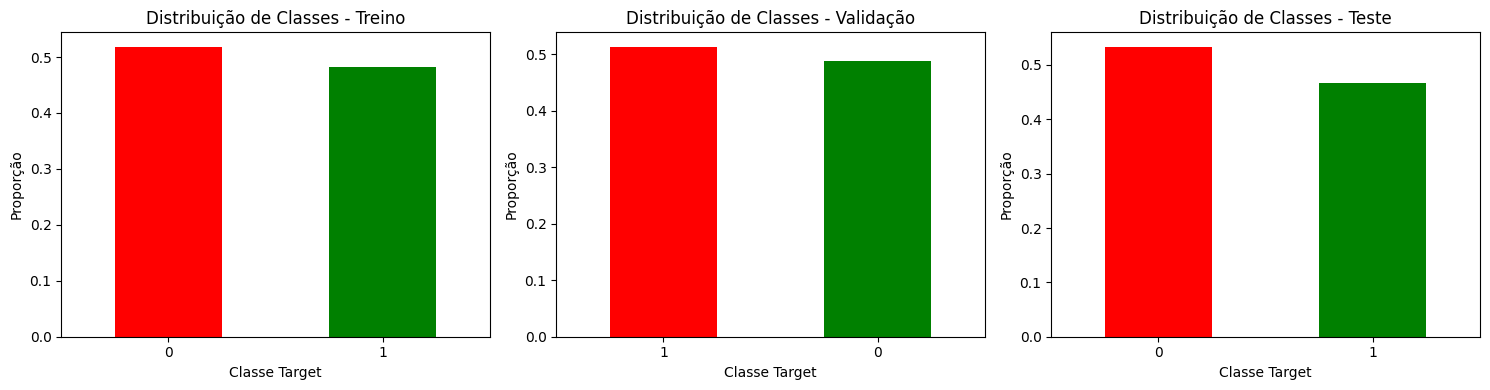

In [23]:
# Separa features e target
colunas_features = [col for col in dados_janela_deslizante.columns if col != 'Target']

X_train = dados_treino[colunas_features]
y_train = dados_treino['Target']
X_val = dados_validacao[colunas_features]
y_val = dados_validacao['Target']
X_test = dados_teste[colunas_features]
y_test = dados_teste['Target']

print(f'=== SEPARA√á√ÉO DE FEATURES E TARGET ===')
print(f'Features: {len(colunas_features)}')
print(f'X_train shape: {X_train.shape}')
print(f'y_train shape: {y_train.shape}')
print(f'X_val shape: {X_val.shape}')
print(f'y_val shape: {y_val.shape}')
print(f'X_test shape: {X_test.shape}')
print(f'y_test shape: {y_test.shape}')

# Verifica distribui√ß√£o de classes
dist_treino = y_train.value_counts(normalize=True)
dist_validacao = y_val.value_counts(normalize=True)
dist_teste = y_test.value_counts(normalize=True)

print(f'\nDistribui√ß√£o de classes no treino:')
for classe, prop in dist_treino.items():
    print(f'   - Classe {classe}: {prop:.2%}')

print(f'Distribui√ß√£o de classes na valida√ß√£o:')
for classe, prop in dist_validacao.items():
    print(f'   - Classe {classe}: {prop:.2%}')

print(f'Distribui√ß√£o de classes no teste:')
for classe, prop in dist_teste.items():
    print(f'   - Classe {classe}: {prop:.2%}')

# Visualiza√ß√£o gr√°fica da distribui√ß√£o
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 4))

# Distribui√ß√£o no treino
dist_treino.plot(kind='bar', ax=ax1, color=['red', 'green'])
ax1.set_title('Distribui√ß√£o de Classes - Treino')
ax1.set_xlabel('Classe Target')
ax1.set_ylabel('Propor√ß√£o')
ax1.tick_params(axis='x', rotation=0)

# Distribui√ß√£o na valida√ß√£o
dist_validacao.plot(kind='bar', ax=ax2, color=['red', 'green'])
ax2.set_title('Distribui√ß√£o de Classes - Valida√ß√£o')
ax2.set_xlabel('Classe Target')
ax2.set_ylabel('Propor√ß√£o')
ax2.tick_params(axis='x', rotation=0)

# Distribui√ß√£o no teste
dist_teste.plot(kind='bar', ax=ax3, color=['red', 'green'])
ax3.set_title('Distribui√ß√£o de Classes - Teste')
ax3.set_xlabel('Classe Target')
ax3.set_ylabel('Propor√ß√£o')
ax3.tick_params(axis='x', rotation=0)

plt.tight_layout()
plt.show()

## Escalonamento de Atributos

### Instancia√ß√£o e Ajuste do StandardScaler

**Importante**: O scaler √© ajustado **APENAS** no conjunto de treino para evitar data leakage.

In [24]:
print(f'=== ESCALONAMENTO DE ATRIBUTOS ===')

# 3.3.1 - Instancia StandardScaler
scaler = StandardScaler()
print('StandardScaler instanciado')

# 3.3.2 - Ajusta APENAS no conjunto de treino
scaler.fit(X_train)
print('Scaler ajustado APENAS nos dados de treino')
print('Isso previne data leakage!')

# Mostra estat√≠sticas do scaler
print(f'\nEstat√≠sticas do scaler (baseadas no treino):')
print(f'   - N√∫mero de features: {len(scaler.mean_)}')
print(f'   - M√©dia das primeiras 5 features: {scaler.mean_[:5]}')
print(f'   - Desvio padr√£o das primeiras 5 features: {scaler.scale_[:5]}')

# 3.3.3 - Aplica transforma√ß√£o em todos os conjuntos
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f'\n=== APLICA√á√ÉO DA TRANSFORMA√á√ÉO ===')
print('Transforma√ß√£o aplicada em treino, valida√ß√£o e teste')
print('Usando os mesmos par√¢metros ajustados no treino')

# Converte de volta para DataFrame mantendo √≠ndices e nomes das colunas
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train.index,
    columns=X_train.columns
)

X_val_scaled = pd.DataFrame(
    X_val_scaled,
    index=X_val.index,
    columns=X_val.columns
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test.index,
    columns=X_test.columns
)

print(f'\nDataFrames escalonados criados:')
print(f'   - X_train_scaled shape: {X_train_scaled.shape}')
print(f'   - X_val_scaled shape: {X_val_scaled.shape}')
print(f'   - X_test_scaled shape: {X_test_scaled.shape}')

# Verifica se a transforma√ß√£o foi aplicada corretamente
print(f'\nVerifica√ß√£o da transforma√ß√£o:')
print(f'   - M√©dia do treino escalonado: {X_train_scaled.mean().mean():.6f} (deve ser ~0)')
print(f'   - Desvio padr√£o do treino escalonado: {X_train_scaled.std().mean():.6f} (deve ser ~1)')

=== ESCALONAMENTO DE ATRIBUTOS ===
StandardScaler instanciado
Scaler ajustado APENAS nos dados de treino
Isso previne data leakage!

Estat√≠sticas do scaler (baseadas no treino):
   - N√∫mero de features: 100
   - M√©dia das primeiras 5 features: [9.00987565e+01 9.00693510e+01 9.08812708e+01 8.92862874e+01
 3.92357166e+08]
   - Desvio padr√£o das primeiras 5 features: [2.87138487e+01 2.87093392e+01 2.88422591e+01 2.85750014e+01
 2.06829672e+09]

=== APLICA√á√ÉO DA TRANSFORMA√á√ÉO ===
Transforma√ß√£o aplicada em treino, valida√ß√£o e teste
Usando os mesmos par√¢metros ajustados no treino

DataFrames escalonados criados:
   - X_train_scaled shape: (2829, 100)
   - X_val_scaled shape: (708, 100)
   - X_test_scaled shape: (30, 100)

Verifica√ß√£o da transforma√ß√£o:
   - M√©dia do treino escalonado: 0.000000 (deve ser ~0)
   - Desvio padr√£o do treino escalonado: 1.000177 (deve ser ~1)


### 5.2 Aplica√ß√£o da Transforma√ß√£o

In [25]:
# Aplica transforma√ß√£o em todos os conjuntos
X_train_scaled = scaler.transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

print(f'=== APLICA√á√ÉO DA TRANSFORMA√á√ÉO ===')
print('Transforma√ß√£o aplicada em treino, valida√ß√£o e teste')
print('Usando os mesmos par√¢metros ajustados no treino')

# Converte de volta para DataFrame mantendo √≠ndices e nomes das colunas
X_train_scaled = pd.DataFrame(
    X_train_scaled,
    index=X_train.index,
    columns=X_train.columns
)

X_val_scaled = pd.DataFrame(
    X_val_scaled,
    index=X_val.index,
    columns=X_val.columns
)

X_test_scaled = pd.DataFrame(
    X_test_scaled,
    index=X_test.index,
    columns=X_test.columns
)

print(f'\nDataFrames escalonados criados:')
print(f'   - X_train_scaled shape: {X_train_scaled.shape}')
print(f'   - X_val_scaled shape: {X_val_scaled.shape}')
print(f'   - X_test_scaled shape: {X_test_scaled.shape}')

# Verifica se a transforma√ß√£o foi aplicada corretamente
media_treino = X_train_scaled.mean().mean()
std_treino = X_train_scaled.std().mean()

print(f'\nVerifica√ß√£o da transforma√ß√£o:')
print(f'   - M√©dia do treino escalonado: {media_treino:.6f} (deve ser ~0)')
print(f'   - Desvio padr√£o do treino escalonado: {std_treino:.6f} (deve ser ~1)')

if abs(media_treino) < 1e-10 and abs(std_treino - 1) < 0.1:
    print('Escalonamento aplicado corretamente!')
else:
    print('Verificar escalonamento - valores fora do esperado')

=== APLICA√á√ÉO DA TRANSFORMA√á√ÉO ===
Transforma√ß√£o aplicada em treino, valida√ß√£o e teste
Usando os mesmos par√¢metros ajustados no treino

DataFrames escalonados criados:
   - X_train_scaled shape: (2829, 100)
   - X_val_scaled shape: (708, 100)
   - X_test_scaled shape: (30, 100)

Verifica√ß√£o da transforma√ß√£o:
   - M√©dia do treino escalonado: 0.000000 (deve ser ~0)
   - Desvio padr√£o do treino escalonado: 1.000177 (deve ser ~1)
Escalonamento aplicado corretamente!


## Visualiza√ß√£o dos Dados Preparados

=== VISUALIZA√á√ÉO DOS DADOS PREPARADOS ===


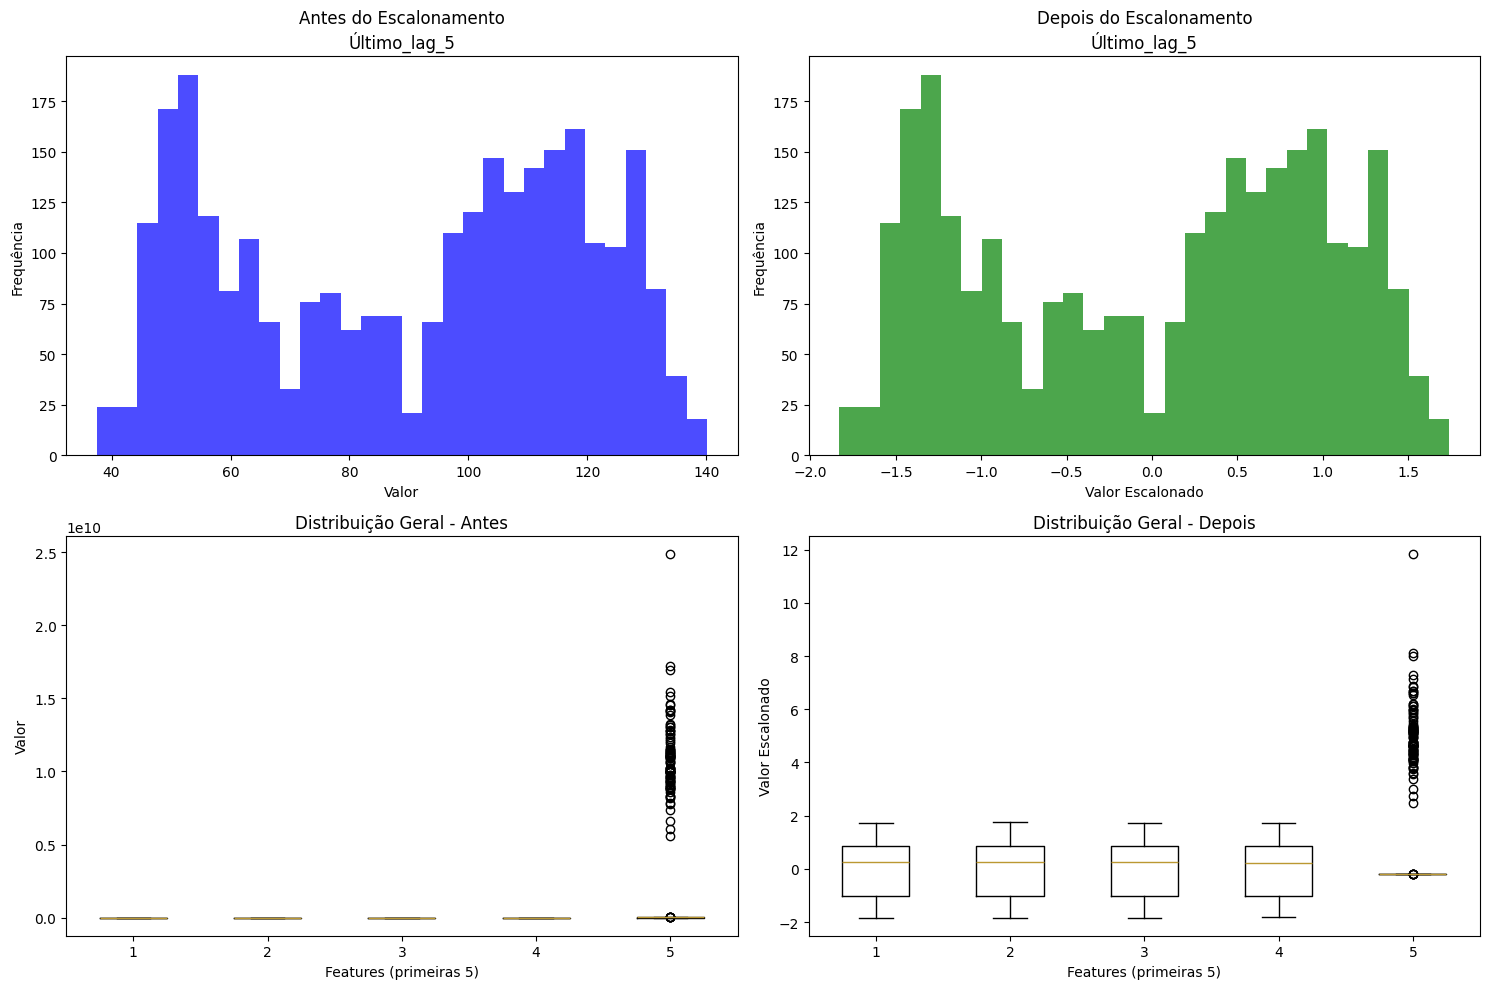


=== ESTAT√çSTICAS DESCRITIVAS ===

Dados ANTES do escalonamento (primeiras 5 features):
       √öltimo_lag_5  Abertura_lag_5  M√°xima_lag_5  M√≠nima_lag_5    Vol._lag_5
count   2829.000000     2829.000000   2829.000000   2829.000000  2.829000e+03
mean      90.098756       90.069351     90.881271     89.286287  3.923572e+08
std       28.718925       28.714415     28.847358     28.580053  2.068662e+09
min       37.497000       37.501000     38.031000     37.046000  4.243200e+05
25%       60.951000       60.800000     61.443000     60.273000  3.650000e+06
50%       97.030000       97.020000     97.937000     96.002000  5.710000e+06
75%      115.166000      115.158000    115.979000    114.277000  1.068000e+07
max      140.110000      140.109000    140.382000    138.966000  2.487000e+10

Dados DEPOIS do escalonamento (primeiras 5 features):
       √öltimo_lag_5  Abertura_lag_5  M√°xima_lag_5  M√≠nima_lag_5   Vol._lag_5
count  2.829000e+03    2.829000e+03  2.829000e+03  2.829000e+03  2829.0

In [26]:
print(f'=== VISUALIZA√á√ÉO DOS DADOS PREPARADOS ===')

# Compara√ß√£o antes e depois do escalonamento
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Primeira feature - antes do escalonamento
primeira_feature = X_train.columns[0]
axes[0, 0].hist(X_train[primeira_feature], bins=30, alpha=0.7, color='blue')
axes[0, 0].set_title(f'Antes do Escalonamento\n{primeira_feature}')
axes[0, 0].set_xlabel('Valor')
axes[0, 0].set_ylabel('Frequ√™ncia')

# Primeira feature - depois do escalonamento
axes[0, 1].hist(X_train_scaled[primeira_feature], bins=30, alpha=0.7, color='green')
axes[0, 1].set_title(f'Depois do Escalonamento\n{primeira_feature}')
axes[0, 1].set_xlabel('Valor Escalonado')
axes[0, 1].set_ylabel('Frequ√™ncia')

# Distribui√ß√£o geral - antes
sample_features = X_train.iloc[:, :5]  # Primeiras 5 features
axes[1, 0].boxplot([sample_features[col].dropna() for col in sample_features.columns])
axes[1, 0].set_title('Distribui√ß√£o Geral - Antes')
axes[1, 0].set_xlabel('Features (primeiras 5)')
axes[1, 0].set_ylabel('Valor')

# Distribui√ß√£o geral - depois
sample_features_scaled = X_train_scaled.iloc[:, :5]  # Primeiras 5 features
axes[1, 1].boxplot([sample_features_scaled[col].dropna() for col in sample_features_scaled.columns])
axes[1, 1].set_title('Distribui√ß√£o Geral - Depois')
axes[1, 1].set_xlabel('Features (primeiras 5)')
axes[1, 1].set_ylabel('Valor Escalonado')

plt.tight_layout()
plt.show()

# Mostra estat√≠sticas descritivas
print('\n=== ESTAT√çSTICAS DESCRITIVAS ===')
print('\nDados ANTES do escalonamento (primeiras 5 features):')
print(X_train.iloc[:, :5].describe())

print('\nDados DEPOIS do escalonamento (primeiras 5 features):')
print(X_train_scaled.iloc[:, :5].describe())

## Salvamento dos Dados Preparados

In [27]:
# Salva os dados preparados
X_train.to_csv('X_train_fase3.csv')
X_val.to_csv('X_val_fase3.csv')
X_test.to_csv('X_test_fase3.csv')
y_train.to_csv('y_train_fase3.csv')
y_val.to_csv('y_val_fase3.csv')
y_test.to_csv('y_test_fase3.csv')

# Salva os dados escalonados
X_train_scaled.to_csv('X_train_scaled_fase3.csv')
X_val_scaled.to_csv('X_val_scaled_fase3.csv')
X_test_scaled.to_csv('X_test_scaled_fase3.csv')

# Salva informa√ß√µes da prepara√ß√£o
info_preparacao = {
    'janela_tamanho': JANELA_TAMANHO,
    'dias_teste': DIAS_TESTE,
    'proporcao_validacao': PROPORCAO_VALIDACAO,
    'data_corte_validacao': str(data_corte_validacao),
    'data_corte_teste': str(data_corte_teste),
    'total_features': len(colunas_features),
    'amostras_treino': len(X_train),
    'amostras_validacao': len(X_val),
    'amostras_teste': len(X_test),
    'features_originais': len(features_numericas),
    'periodo_treino': f'{X_train.index.min()} at√© {X_train.index.max()}',
    'periodo_validacao': f'{X_val.index.min()} at√© {X_val.index.max()}',
    'periodo_teste': f'{X_test.index.min()} at√© {X_test.index.max()}'
}

with open('info_preparacao_fase3.json', 'w', encoding='utf-8') as f:
    json.dump(info_preparacao, f, indent=2, ensure_ascii=False, default=str)

# Fase 4: Modelagem e Valida√ß√£o

A Fase 4 √© a etapa de execu√ß√£o e aferi√ß√£o de performance dos modelos. Neste ponto, os algoritmos s√£o treinados com o conjunto de dados de treino para aprender as rela√ß√µes entre os atributos e o alvo. O objetivo principal √© desenvolver um modelo que n√£o apenas se ajuste bem aos dados vistos, mas que tamb√©m generalize seu aprendizado para dados futuros. O risco central a ser mitigado √© o sobreajuste (overfitting), onde o modelo memoriza o ru√≠do em vez dos padr√µes, tornando-se ineficaz na pr√°tica. A valida√ß√£o rigorosa com o conjunto de teste √©, portanto, o procedimento cr√≠tico que quantifica a real capacidade preditiva do modelo.

## Imports

In [28]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, precision_score, recall_score, f1_score
import xgboost as xgb
from sklearn.model_selection import TimeSeriesSplit
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')


plt.style.use('default')
sns.set_palette("husl")

## Carregamento dos Dados Preparados

In [29]:
# Carrega dados escalonados
X_train_scaled = pd.read_csv('X_train_scaled_fase3.csv', index_col=0, parse_dates=True)
X_val_scaled = pd.read_csv('X_val_scaled_fase3.csv', index_col=0, parse_dates=True)
X_test_scaled = pd.read_csv('X_test_scaled_fase3.csv', index_col=0, parse_dates=True)
    
# Carrega targets
y_train = pd.read_csv('y_train_fase3.csv', index_col=0, parse_dates=True).squeeze()
y_val = pd.read_csv('y_val_fase3.csv', index_col=0, parse_dates=True).squeeze()
y_test = pd.read_csv('y_test_fase3.csv', index_col=0, parse_dates=True).squeeze()
    
# Carrega informa√ß√µes da prepara√ß√£o
with open('info_preparacao_fase3.json', 'r', encoding='utf-8') as f:
    info_preparacao = json.load(f)
    
# Estrutura os dados conforme esperado pela Fase 4
dados_preparados = {
    'X_train_scaled': X_train_scaled,
    'y_train': y_train,
    'X_val_scaled': X_val_scaled,
    'y_val': y_val,
    'X_test_scaled': X_test_scaled,
    'y_test': y_test,
    'info_preparacao': info_preparacao
}

print("Dados estruturados para modelagem")
print(f"Amostras de treino: {len(X_train_scaled)}")
print(f"Amostras de valida√ß√£o: {len(X_val_scaled)}")
print(f"Amostras de teste: {len(X_test_scaled)}")
print(f"N√∫mero de features: {X_train_scaled.shape[1]}")
print(f"Janela deslizante: {info_preparacao['janela_tamanho']} dias")
print(f"Per√≠odo treino: {info_preparacao['periodo_treino']}")
print(f"Per√≠odo valida√ß√£o: {info_preparacao['periodo_validacao']}")
print(f"Per√≠odo teste: {info_preparacao['periodo_teste']}")

Dados estruturados para modelagem
Amostras de treino: 2829
Amostras de valida√ß√£o: 708
Amostras de teste: 30
N√∫mero de features: 100
Janela deslizante: 5 dias
Per√≠odo treino: 2013-12-20 00:00:00 at√© 2025-05-26 00:00:00
Per√≠odo valida√ß√£o: 2011-02-15 00:00:00 at√© 2013-12-19 00:00:00
Per√≠odo teste: 2011-01-03 00:00:00 at√© 2011-02-14 00:00:00


## Otimiza√ß√£o de Hiperpar√¢metros dos Modelos

In [30]:
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

# Dados para otimiza√ß√£o (treino + valida√ß√£o)
X_opt = pd.concat([X_train_scaled, X_val_scaled])
y_opt = pd.concat([y_train, y_val])

# Configura√ß√£o da valida√ß√£o cruzada temporal
tscv = TimeSeriesSplit(n_splits=3)

# Calcula scale_pos_weight
contagem_classes = y_opt.value_counts()
scale_pos_weight_opt = contagem_classes[0] / contagem_classes[1] if 1 in contagem_classes else 1

print(f"Dados para otimiza√ß√£o: {len(X_opt)} amostras")
print(f"Scale pos weight: {scale_pos_weight_opt:.4f}")

# 1. OTIMIZA√á√ÉO REGRESS√ÉO LOG√çSTICA

param_grid_logreg = {
    'C': [0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'saga'],
    'max_iter': [1000]
}

grid_logreg = GridSearchCV(
    estimator=LogisticRegression(random_state=42),
    param_grid=param_grid_logreg,
    scoring='f1',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_logreg.fit(X_opt, y_opt)
melhor_logreg = grid_logreg.best_estimator_

print(f"‚úì Melhores par√¢metros LogReg: {grid_logreg.best_params_}")
print(f"‚úì Melhor F1-Score CV: {grid_logreg.best_score_:.4f}")

# 2. OTIMIZA√á√ÉO XGBOOST
print("\n‚ö° Otimizando XGBoost...")

param_grid_xgb = {
    #'n_estimators': [100, 200],
    'n_estimators': [100, 250, 500],
    #'max_depth': [4, 6, 8],
    'max_depth': [3, 4, 5],
    #'learning_rate': [0.05, 0.1, 0.15],
    'learning_rate': [0.01, 0.05, 0.1],
    #'subsample': [0.8, 0.9],
    'subsample': [0.7, 0.8],
    #'colsample_bytree': [0.8, 0.9],
    'colsample_bytree': [0.7, 0.8],
    'gamma': [0, 0.1, 0.5, 1],      #novo
    'reg_lambda': [0.1, 1.0, 5.0],  #novo
    'reg_alpha': [0, 0.001, 0.005] #novo

}

grid_xgb = GridSearchCV(
    estimator=xgb.XGBClassifier(
        scale_pos_weight=scale_pos_weight_opt,
        random_state=42,
        eval_metric='logloss'
    ),
    param_grid=param_grid_xgb,
    scoring='f1',
    cv=tscv,
    n_jobs=-1,
    verbose=1
)

grid_xgb.fit(X_opt, y_opt)
melhor_xgb = grid_xgb.best_estimator_

print(f"‚úì Melhores par√¢metros XGB: {grid_xgb.best_params_}")
print(f"‚úì Melhor F1-Score CV: {grid_xgb.best_score_:.4f}")

# Armazena modelos otimizados
modelos_otimizados = {
    'logreg': melhor_logreg,
    'xgboost': melhor_xgb,
    'params_logreg': grid_logreg.best_params_,
    'params_xgb': grid_xgb.best_params_,
    'score_logreg': grid_logreg.best_score_,
    'score_xgb': grid_xgb.best_score_
}

print(f"\nüéØ OTIMIZA√á√ÉO CONCLU√çDA!")
print(f"   üìä Modelos otimizados salvos em 'modelos_otimizados'")

Dados para otimiza√ß√£o: 3537 amostras
Scale pos weight: 1.0492
Fitting 3 folds for each of 16 candidates, totalling 48 fits
‚úì Melhores par√¢metros LogReg: {'C': 0.01, 'max_iter': 1000, 'penalty': 'l2', 'solver': 'saga'}
‚úì Melhor F1-Score CV: 0.5303

‚ö° Otimizando XGBoost...
Fitting 3 folds for each of 3888 candidates, totalling 11664 fits
‚úì Melhores par√¢metros XGB: {'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0.001, 'reg_lambda': 1.0, 'subsample': 0.8}
‚úì Melhor F1-Score CV: 0.5506

üéØ OTIMIZA√á√ÉO CONCLU√çDA!
   üìä Modelos otimizados salvos em 'modelos_otimizados'


## Treinamento do Modelo Baseline (Regress√£o Log√≠stica)

Instanciar e treinar um modelo de Regress√£o Log√≠stica; Realizar previs√µes no conjunto de teste

In [31]:
print("=== TREINAMENTO DO MODELO BASELINE (REGRESS√ÉO LOG√çSTICA) ===")

# Extrai dados
X_train = dados_preparados['X_train_scaled']
y_train = dados_preparados['y_train']
X_val = dados_preparados['X_val_scaled']
y_val = dados_preparados['y_val']
X_test = dados_preparados['X_test_scaled']
y_test = dados_preparados['y_test']

# Instancia e treina Regress√£o Log√≠stica
modelo_baseline = modelos_otimizados['logreg']

modelo_baseline.fit(X_train, y_train)

# Realiza previs√µes nos conjuntos de valida√ß√£o e teste
y_pred_val_baseline = modelo_baseline.predict(X_val)
y_pred_proba_val_baseline = modelo_baseline.predict_proba(X_val)[:, 1]

y_pred_test_baseline = modelo_baseline.predict(X_test)
y_pred_proba_test_baseline = modelo_baseline.predict_proba(X_test)[:, 1]

# Armazena resultados
resultados_baseline = {
    'modelo': modelo_baseline,
    'y_pred_val': y_pred_val_baseline,
    'y_pred_proba_val': y_pred_proba_val_baseline,
    'y_true_val': y_val,
    'y_pred_test': y_pred_test_baseline,
    'y_pred_proba_test': y_pred_proba_test_baseline,
    'y_true_test': y_test
}

print(f"Modelo de Regress√£o Log√≠stica treinado")
print(f"Previs√µes realizadas nos conjuntos de valida√ß√£o e teste")

=== TREINAMENTO DO MODELO BASELINE (REGRESS√ÉO LOG√çSTICA) ===
Modelo de Regress√£o Log√≠stica treinado
Previs√µes realizadas nos conjuntos de valida√ß√£o e teste


## Treinamento do Modelo Principal (XGBoost)

Instanciar um XGBClassifier;
Configurar scale_pos_weight para desbalanceamento;
Treinar o modelo;
Realizar previs√µes.

In [32]:
print("=== TREINAMENTO DO MODELO PRINCIPAL (XGBOOST) ===")

# Calcula scale_pos_weight para balanceamento
contagem_classes = y_train.value_counts()
scale_pos_weight = contagem_classes[0] / contagem_classes[1] if 1 in contagem_classes else 1

print(f"Scale pos weight calculado: {scale_pos_weight:.4f}")

# Instancia XGBClassifier com configura√ß√µes
modelo_xgboost = modelos_otimizados['xgboost']

# Treina o modelo
modelo_xgboost.fit(X_train, y_train)

# Realiza previs√µes nos conjuntos de valida√ß√£o e teste
y_pred_val_xgb = modelo_xgboost.predict(X_val)
y_pred_proba_val_xgb = modelo_xgboost.predict_proba(X_val)[:, 1]

y_pred_test_xgb = modelo_xgboost.predict(X_test)
y_pred_proba_test_xgb = modelo_xgboost.predict_proba(X_test)[:, 1]

# Armazena resultados
resultados_xgboost = {
    'modelo': modelo_xgboost,
    'y_pred_val': y_pred_val_xgb,
    'y_pred_proba_val': y_pred_proba_val_xgb,
    'y_true_val': y_val,
    'y_pred_test': y_pred_test_xgb,
    'y_pred_proba_test': y_pred_proba_test_xgb,
    'y_true_test': y_test,
    'feature_importance': modelo_xgboost.feature_importances_
}

print(f"Modelo XGBoost treinado")
print(f"Previs√µes realizadas nos conjuntos de valida√ß√£o e teste")


=== TREINAMENTO DO MODELO PRINCIPAL (XGBOOST) ===
Scale pos weight calculado: 1.0756
Modelo XGBoost treinado
Previs√µes realizadas nos conjuntos de valida√ß√£o e teste


## Avalia√ß√£o de M√©tricas de Desempenho

### Calcular e analisar m√©tricas para ambos os modelos
- Matriz de Confus√£o
- Precis√£o (Precision)
- Revoca√ß√£o (Recall)
- F1-Score

In [33]:
def avaliar_metricas_desempenho(resultados, nome_modelo, conjunto='validacao'):
    """
    Calcula e exibe m√©tricas de desempenho para um modelo.
    
    Par√¢metros:
    -----------
    resultados : dict
        Dicion√°rio com resultados do modelo
    nome_modelo : str
        Nome do modelo para exibi√ß√£o
    conjunto : str
        'validacao' ou 'teste' para especificar qual conjunto avaliar
    """
    if conjunto == 'validacao':
        y_true = resultados['y_true_val']
        y_pred = resultados['y_pred_val']
    else:  # teste
        y_true = resultados['y_true_test']
        y_pred = resultados['y_pred_test']
    
    print(f"\n=== AVALIA√á√ÉO DE M√âTRICAS - {nome_modelo.upper()} ({conjunto.upper()}) ===")
    
    # Matriz de Confus√£o
    cm = confusion_matrix(y_true, y_pred)
    
    # M√©tricas
    precision = precision_score(y_true, y_pred, average='binary')
    recall = recall_score(y_true, y_pred, average='binary')
    f1 = f1_score(y_true, y_pred, average='binary')
    accuracy = (y_pred == y_true).mean()
    
    # Relat√≥rio detalhado
    report = classification_report(y_true, y_pred, output_dict=True)
    
    metricas = {
        'matriz_confusao': cm,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'accuracy': accuracy,
        'classification_report': report,
        'conjunto': conjunto
    }
    
    # Exibe resultados
    print(f"‚úì Matriz de Confus√£o:")
    print(f"   [[TN={cm[0,0]}, FP={cm[0,1]}],")
    print(f"    [FN={cm[1,0]}, TP={cm[1,1]}]]")
    
    print(f"\n‚úì M√©tricas de Desempenho:")
    print(f"   - Acur√°cia: {accuracy:.4f}")
    print(f"   - Precis√£o: {precision:.4f}")
    print(f"   - Recall: {recall:.4f}")
    print(f"   - F1-Score: {f1:.4f}")
    
    # Interpreta√ß√£o das m√©tricas
    print(f"\n‚úì Interpreta√ß√£o:")
    print(f"   - Precis√£o: {precision:.2%} das previs√µes de 'alta' est√£o corretas")
    print(f"   - Recall: {recall:.2%} dos dias de 'alta' foram identificados")
    print(f"   - F1-Score: {f1:.4f} (m√©dia harm√¥nica de precis√£o e recall)")
    
    return metricas

# Avalia modelo baseline na valida√ß√£o
metricas_baseline_val = avaliar_metricas_desempenho(resultados_baseline, "Regress√£o Log√≠stica", "validacao")

# Avalia modelo XGBoost na valida√ß√£o
metricas_xgboost_val = avaliar_metricas_desempenho(resultados_xgboost, "XGBoost", "validacao")


=== AVALIA√á√ÉO DE M√âTRICAS - REGRESS√ÉO LOG√çSTICA (VALIDACAO) ===
‚úì Matriz de Confus√£o:
   [[TN=189, FP=156],
    [FN=191, TP=172]]

‚úì M√©tricas de Desempenho:
   - Acur√°cia: 0.5099
   - Precis√£o: 0.5244
   - Recall: 0.4738
   - F1-Score: 0.4978

‚úì Interpreta√ß√£o:
   - Precis√£o: 52.44% das previs√µes de 'alta' est√£o corretas
   - Recall: 47.38% dos dias de 'alta' foram identificados
   - F1-Score: 0.4978 (m√©dia harm√¥nica de precis√£o e recall)

=== AVALIA√á√ÉO DE M√âTRICAS - XGBOOST (VALIDACAO) ===
‚úì Matriz de Confus√£o:
   [[TN=221, FP=124],
    [FN=215, TP=148]]

‚úì M√©tricas de Desempenho:
   - Acur√°cia: 0.5212
   - Precis√£o: 0.5441
   - Recall: 0.4077
   - F1-Score: 0.4661

‚úì Interpreta√ß√£o:
   - Precis√£o: 54.41% das previs√µes de 'alta' est√£o corretas
   - Recall: 40.77% dos dias de 'alta' foram identificados
   - F1-Score: 0.4661 (m√©dia harm√¥nica de precis√£o e recall)


In [34]:
# Avalia modelo baseline no teste
metricas_baseline_teste = avaliar_metricas_desempenho(resultados_baseline, "Regress√£o Log√≠stica", "teste")

# Avalia modelo XGBoost no teste
metricas_xgboost_teste = avaliar_metricas_desempenho(resultados_xgboost, "XGBoost", "teste")


=== AVALIA√á√ÉO DE M√âTRICAS - REGRESS√ÉO LOG√çSTICA (TESTE) ===
‚úì Matriz de Confus√£o:
   [[TN=9, FP=7],
    [FN=8, TP=6]]

‚úì M√©tricas de Desempenho:
   - Acur√°cia: 0.5000
   - Precis√£o: 0.4615
   - Recall: 0.4286
   - F1-Score: 0.4444

‚úì Interpreta√ß√£o:
   - Precis√£o: 46.15% das previs√µes de 'alta' est√£o corretas
   - Recall: 42.86% dos dias de 'alta' foram identificados
   - F1-Score: 0.4444 (m√©dia harm√¥nica de precis√£o e recall)

=== AVALIA√á√ÉO DE M√âTRICAS - XGBOOST (TESTE) ===
‚úì Matriz de Confus√£o:
   [[TN=13, FP=3],
    [FN=10, TP=4]]

‚úì M√©tricas de Desempenho:
   - Acur√°cia: 0.5667
   - Precis√£o: 0.5714
   - Recall: 0.2857
   - F1-Score: 0.3810

‚úì Interpreta√ß√£o:
   - Precis√£o: 57.14% das previs√µes de 'alta' est√£o corretas
   - Recall: 28.57% dos dias de 'alta' foram identificados
   - F1-Score: 0.3810 (m√©dia harm√¥nica de precis√£o e recall)


## Visualiza√ß√£o das Matrizes de Confus√£o

=== MATRIZES DE CONFUS√ÉO - CONJUNTO DE VALIDA√á√ÉO ===


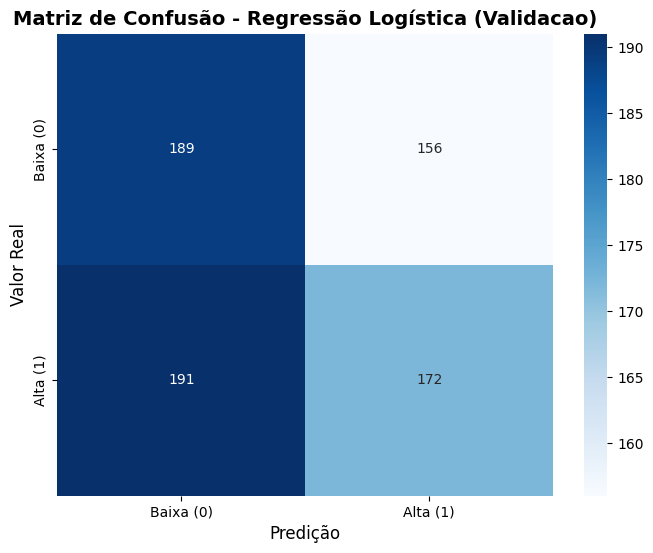


=== MATRIZES DE CONFUS√ÉO - CONJUNTO DE TESTE ===


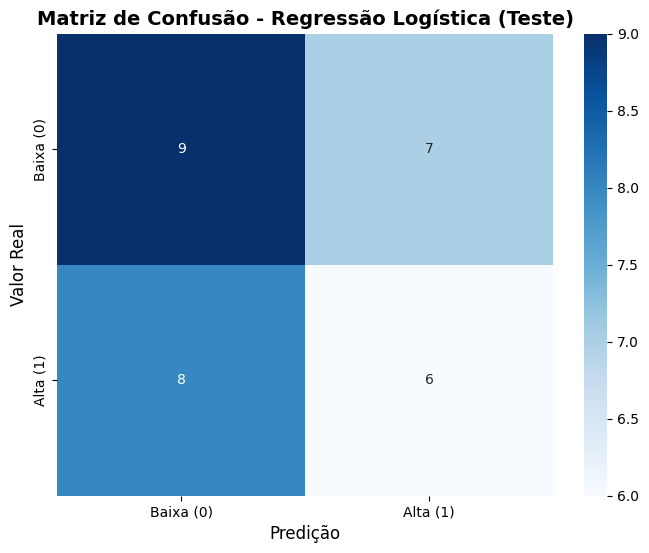

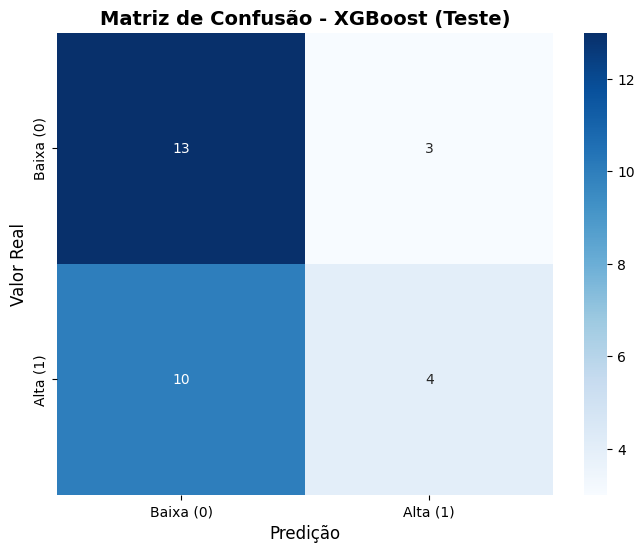

In [35]:
def plotar_matriz_confusao(resultados, nome_modelo, conjunto='validacao', salvar_grafico=False):
    """
    Plota a matriz de confus√£o de forma visual.
    
    Par√¢metros:
    -----------
    resultados : dict
        Dicion√°rio com resultados do modelo
    nome_modelo : str
        Nome do modelo para exibi√ß√£o
    conjunto : str
        'validacao' ou 'teste' para especificar qual conjunto plotar
    salvar_grafico : bool
        Se True, salva o gr√°fico
    """
    if conjunto == 'validacao':
        y_true = resultados['y_true_val']
        y_pred = resultados['y_pred_val']
    else:  # teste
        y_true = resultados['y_true_test']
        y_pred = resultados['y_pred_test']
    
    cm = confusion_matrix(y_true, y_pred)
    
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
               xticklabels=['Baixa (0)', 'Alta (1)'],
               yticklabels=['Baixa (0)', 'Alta (1)'])
    plt.title(f'Matriz de Confus√£o - {nome_modelo} ({conjunto.title()})', fontsize=14, fontweight='bold')
    plt.xlabel('Predi√ß√£o', fontsize=12)
    plt.ylabel('Valor Real', fontsize=12)
    
    if salvar_grafico:
        nome_arquivo = f'matriz_confusao_{nome_modelo.lower().replace(" ", "_")}_{conjunto}.png'
        plt.savefig(f'Tech Challenge 2/final/{nome_arquivo}', 
                   dpi=300, bbox_inches='tight')
    
    plt.show()

# Plota matrizes de confus√£o para valida√ß√£o
print("=== MATRIZES DE CONFUS√ÉO - CONJUNTO DE VALIDA√á√ÉO ===")
plotar_matriz_confusao(resultados_baseline, "Regress√£o Log√≠stica", "validacao")
plotar_matriz_confusao(resultados_xgboost, "XGBoost", "validacao")

# Plota matrizes de confus√£o para teste
print("\n=== MATRIZES DE CONFUS√ÉO - CONJUNTO DE TESTE ===")
plotar_matriz_confusao(resultados_baseline, "Regress√£o Log√≠stica", "teste")
plotar_matriz_confusao(resultados_xgboost, "XGBoost", "teste")

## Valida√ß√£o Walk-Forward

Implementar valida√ß√£o walk-forward com 3 dobras; 
Treinar XGBoost para cada dobra; 
Coletar m√©tricas de cada dobra; 
Calcular m√©dia e desvio padr√£o.

In [36]:
def validacao_walk_forward(dados_preparados, n_splits=3):
    """
    Implementa valida√ß√£o walk-forward simplificada.
    """
    print(f"=== VALIDA√á√ÉO WALK-FORWARD ({n_splits} DOBRAS) ===")
    
    # Dados completos (treino + valida√ß√£o + teste)
    X_completo = pd.concat([
        dados_preparados['X_train_scaled'], 
        dados_preparados['X_val_scaled'],
        dados_preparados['X_test_scaled']
    ])
    y_completo = pd.concat([
        dados_preparados['y_train'], 
        dados_preparados['y_val'],
        dados_preparados['y_test']
    ])
    
    # Configura√ß√£o do TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=n_splits)
    
    metricas_dobras = []
    
    for i, (train_idx, test_idx) in enumerate(tscv.split(X_completo)):
        print(f"\n--- Dobra {i+1}/{n_splits} ---")
        
        # Dados da dobra
        X_train_fold = X_completo.iloc[train_idx]
        y_train_fold = y_completo.iloc[train_idx]
        X_test_fold = X_completo.iloc[test_idx]
        y_test_fold = y_completo.iloc[test_idx]
        
        # Calcula scale_pos_weight para a dobra
        contagem_classes = y_train_fold.value_counts()
        scale_pos_weight = contagem_classes[0] / contagem_classes[1] if 1 in contagem_classes else 1
        
        # Treina modelo XGBoost para a dobra
        modelo_fold = xgb.XGBClassifier(
            **modelos_otimizados['params_xgb'],
            scale_pos_weight=scale_pos_weight,
            random_state=5,
            eval_metric='logloss'
        )
        
        modelo_fold.fit(X_train_fold, y_train_fold)
        
        # Previs√µes
        y_pred_fold = modelo_fold.predict(X_test_fold)
        
        # M√©tricas da dobra
        precision_fold = precision_score(y_test_fold, y_pred_fold, average='binary')
        recall_fold = recall_score(y_test_fold, y_pred_fold, average='binary')
        f1_fold = f1_score(y_test_fold, y_pred_fold, average='binary')
        accuracy_fold = (y_pred_fold == y_test_fold).mean()
        
        metricas_fold = {
            'dobra': i+1,
            'precision': precision_fold,
            'recall': recall_fold,
            'f1_score': f1_fold,
            'accuracy': accuracy_fold,
            'periodo_treino': f"{X_train_fold.index.min()} at√© {X_train_fold.index.max()}",
            'periodo_teste': f"{X_test_fold.index.min()} at√© {X_test_fold.index.max()}",
            'amostras_treino': len(X_train_fold),
            'amostras_teste': len(X_test_fold)
        }
        
        metricas_dobras.append(metricas_fold)
        
        print(f"   Per√≠odo treino: {metricas_fold['periodo_treino']}")
        print(f"   Per√≠odo teste: {metricas_fold['periodo_teste']}")
        print(f"   F1-Score: {f1_fold:.4f}")
        print(f"   Precis√£o: {precision_fold:.4f}")
        print(f"   Recall: {recall_fold:.4f}")
    
    return metricas_dobras

# Executa valida√ß√£o walk-forward
metricas_dobras = validacao_walk_forward(dados_preparados, n_splits=3)

=== VALIDA√á√ÉO WALK-FORWARD (3 DOBRAS) ===

--- Dobra 1/3 ---
   Per√≠odo treino: 2021-10-22 00:00:00 at√© 2025-05-26 00:00:00
   Per√≠odo teste: 2018-03-19 00:00:00 at√© 2021-10-21 00:00:00
   F1-Score: 0.5899
   Precis√£o: 0.4740
   Recall: 0.7810

--- Dobra 2/3 ---
   Per√≠odo treino: 2018-03-19 00:00:00 at√© 2025-05-26 00:00:00
   Per√≠odo teste: 2014-08-08 00:00:00 at√© 2018-03-16 00:00:00
   F1-Score: 0.5728
   Precis√£o: 0.4924
   Recall: 0.6846

--- Dobra 3/3 ---
   Per√≠odo treino: 2014-08-08 00:00:00 at√© 2025-05-26 00:00:00
   Per√≠odo teste: 2011-01-03 00:00:00 at√© 2014-08-07 00:00:00
   F1-Score: 0.4706
   Precis√£o: 0.5465
   Recall: 0.4132


### Calcula estat√≠sticas agregadas

In [37]:
# Calcula estat√≠sticas agregadas
df_metricas = pd.DataFrame(metricas_dobras)

estatisticas_agregadas = {
    'precision_media': df_metricas['precision'].mean(),
    'precision_std': df_metricas['precision'].std(),
    'recall_media': df_metricas['recall'].mean(),
    'recall_std': df_metricas['recall'].std(),
    'f1_score_media': df_metricas['f1_score'].mean(),
    'f1_score_std': df_metricas['f1_score'].std(),
    'accuracy_media': df_metricas['accuracy'].mean(),
    'accuracy_std': df_metricas['accuracy'].std()
}

resultados_walk_forward = {
    'metricas_por_dobra': metricas_dobras,
    'estatisticas_agregadas': estatisticas_agregadas,
    'dataframe_metricas': df_metricas
}

print(f"\n=== RESULTADOS AGREGADOS DA VALIDA√á√ÉO WALK-FORWARD ===")
print(f"‚úì F1-Score: {estatisticas_agregadas['f1_score_media']:.4f} ¬± {estatisticas_agregadas['f1_score_std']:.4f}")
print(f"‚úì Precis√£o: {estatisticas_agregadas['precision_media']:.4f} ¬± {estatisticas_agregadas['precision_std']:.4f}")
print(f"‚úì Recall: {estatisticas_agregadas['recall_media']:.4f} ¬± {estatisticas_agregadas['recall_std']:.4f}")
print(f"‚úì Acur√°cia: {estatisticas_agregadas['accuracy_media']:.4f} ¬± {estatisticas_agregadas['accuracy_std']:.4f}")

# Exibe tabela com resultados por dobra
print("\n=== M√âTRICAS POR DOBRA ===")
display(df_metricas[['dobra', 'precision', 'recall', 'f1_score', 'accuracy', 'amostras_treino', 'amostras_teste']])


=== RESULTADOS AGREGADOS DA VALIDA√á√ÉO WALK-FORWARD ===
‚úì F1-Score: 0.5444 ¬± 0.0645
‚úì Precis√£o: 0.5043 ¬± 0.0377
‚úì Recall: 0.6262 ¬± 0.1907
‚úì Acur√°cia: 0.5077 ¬± 0.0186

=== M√âTRICAS POR DOBRA ===


dobra  precision    recall  f1_score  accuracy  amostras_treino  \
0      1   0.473988  0.780952  0.589928  0.488215              894   
1      2   0.492437  0.684579  0.572825  0.509540             1785   
2      3   0.546512  0.413187  0.470588  0.525253             2676   

   amostras_teste  
0             891  
1             891  
2             891

## Visualiza√ß√£o dos Resultados da Valida√ß√£o Walk-Forward

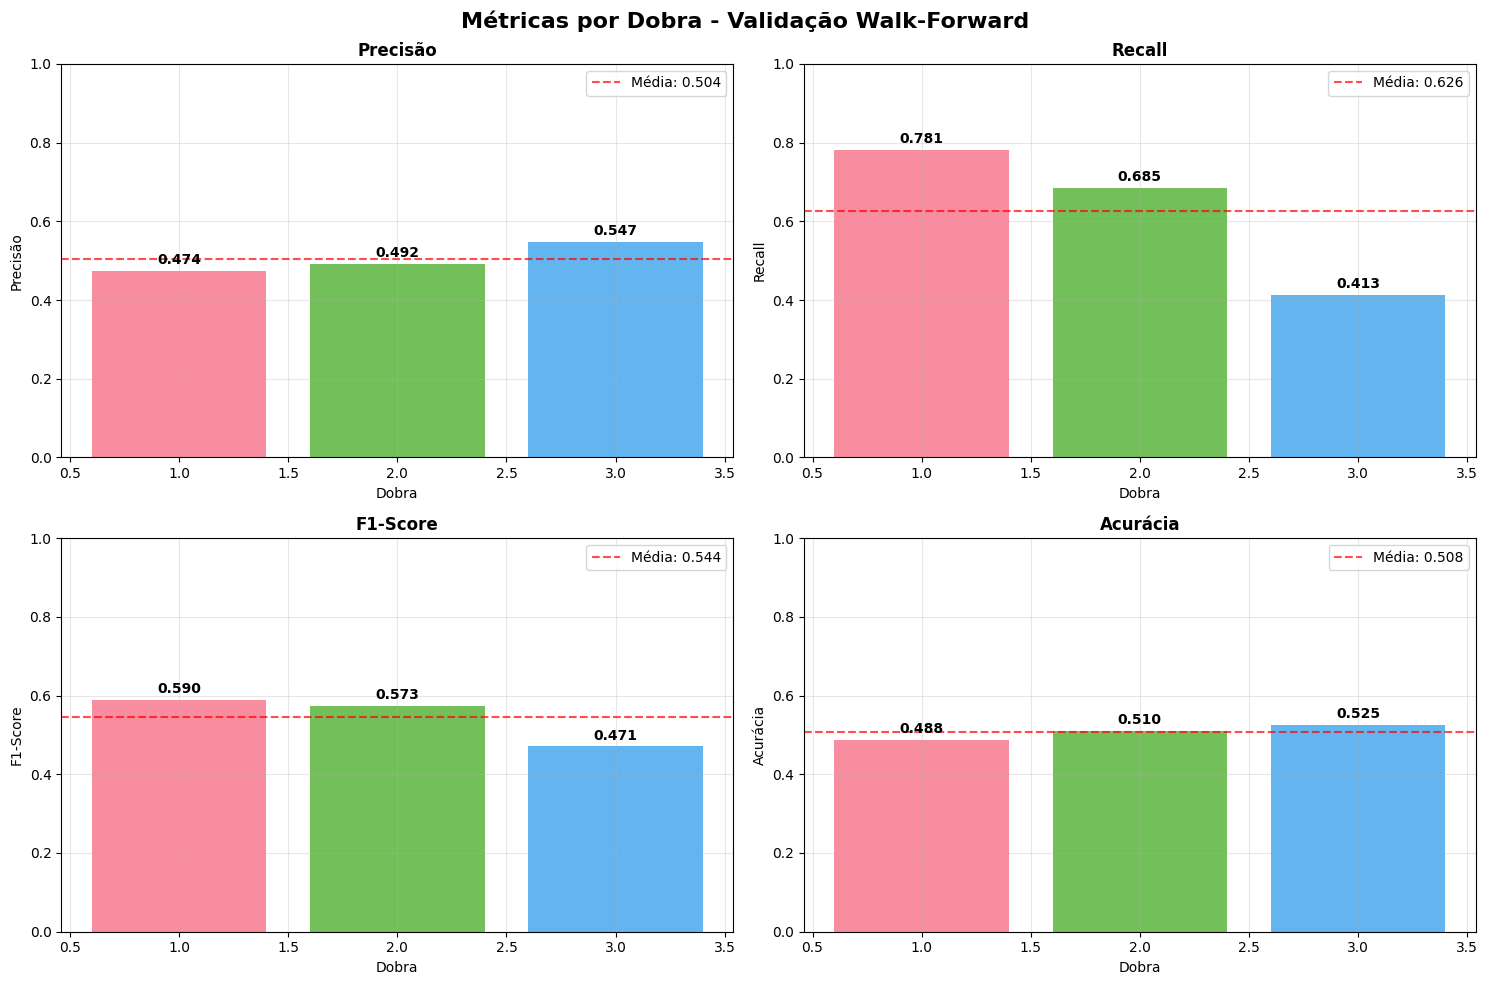

In [38]:
# Gr√°fico de barras com as m√©tricas por dobra
fig, axes = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('M√©tricas por Dobra - Valida√ß√£o Walk-Forward', fontsize=16, fontweight='bold')

metricas_plot = ['precision', 'recall', 'f1_score', 'accuracy']
titulos = ['Precis√£o', 'Recall', 'F1-Score', 'Acur√°cia']

for i, (metrica, titulo) in enumerate(zip(metricas_plot, titulos)):
    ax = axes[i//2, i%2]
    
    bars = ax.bar(df_metricas['dobra'], df_metricas[metrica], 
                  color=sns.color_palette("husl", len(df_metricas)), alpha=0.8)
    
    # Adiciona valores nas barras
    for bar, valor in zip(bars, df_metricas[metrica]):
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01,
                f'{valor:.3f}', ha='center', va='bottom', fontweight='bold')
    
    # Linha da m√©dia
    media = df_metricas[metrica].mean()
    ax.axhline(y=media, color='red', linestyle='--', alpha=0.7, 
               label=f'M√©dia: {media:.3f}')
    
    ax.set_title(titulo, fontsize=12, fontweight='bold')
    ax.set_xlabel('Dobra')
    ax.set_ylabel(titulo)
    ax.set_ylim(0, 1)
    ax.legend()
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Compara√ß√£o Final dos Modelos

In [39]:
# Tabela comparativa final
comparacao_final = pd.DataFrame({
    'Modelo': ['Regress√£o Log√≠stica', 'XGBoost', 'XGBoost (Walk-Forward)'],
    'Precis√£o': [
        metricas_baseline_val['precision'],
        metricas_xgboost_val['precision'],
        estatisticas_agregadas['precision_media']
    ],
    'Recall': [
        metricas_baseline_val['recall'],
        metricas_xgboost_val['recall'],
        estatisticas_agregadas['recall_media']
    ],
    'F1-Score': [
        metricas_baseline_val['f1_score'],
        metricas_xgboost_val['f1_score'],
        estatisticas_agregadas['f1_score_media']
    ],
    'Acur√°cia': [
        metricas_baseline_val['accuracy'],
        metricas_xgboost_val['accuracy'],
        estatisticas_agregadas['accuracy_media']
    ]
})

print("=== COMPARA√á√ÉO FINAL DOS MODELOS ===")
display(comparacao_final.round(4))

# Identifica o melhor modelo
melhor_f1 = comparacao_final.loc[comparacao_final['F1-Score'].idxmax()]
print(f"\n‚úì Melhor modelo por F1-Score: {melhor_f1['Modelo']} (F1: {melhor_f1['F1-Score']:.4f})")


=== COMPARA√á√ÉO FINAL DOS MODELOS ===


Modelo  Precis√£o  Recall  F1-Score  Acur√°cia
0     Regress√£o Log√≠stica    0.5244  0.4738    0.4978    0.5099
1                 XGBoost    0.5441  0.4077    0.4661    0.5212
2  XGBoost (Walk-Forward)    0.5043  0.6262    0.5444    0.5077


‚úì Melhor modelo por F1-Score: XGBoost (Walk-Forward) (F1: 0.5444)
